In [5]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation, cm, figure
import pandas as pd
import matplotlib.patheffects as path_effects
from matplotlib.offsetbox import AnchoredText
from matplotlib.animation import FFMpegWriter, FFMpegFileWriter, MovieWriter
from matplotlib import animation, cm, figure
from datetime import datetime
import ffmpeg
import cv2
import pydicom
from scipy import signal
from IPython.display import HTML

import os
import sys


### 

## Week 1: May 17th
##### Learn how to use functions from util.py to analyse ultrasound images

### Import functions from "util.py"

In [6]:
from util import  extract_ultrasound_from_dicom,analyse_flow_from_dicom,get_flow_map, make_animation, apply_time_filter, compose_flow_overlay, apply_alpha,calculate_scores

### Extract pixel values from ultrasound data and time per frame

In [7]:
us_data, timestep = extract_ultrasound_from_dicom("files/3007889_0051.dcm")

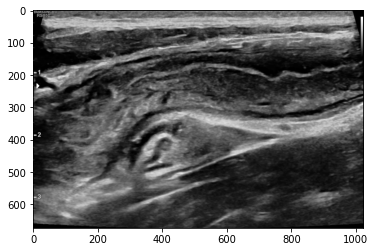

In [6]:
plt.imshow(us_data[23], cmap = "Greys_r")

### Compute flow magnitudes

In [15]:
flow_map = get_flow_map(us_data)

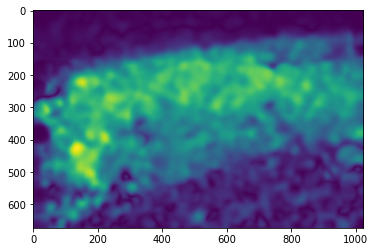

In [16]:
plt.imshow(flow_map[23])

In [49]:
flow_magnitudes_smooth = apply_time_filter(flow_map)

In [96]:
plt.imshow(flow_magnitudes_smooth[21])

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/Users/angie/miniconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3325, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-96-30d35d17ce9f>", line 1, in <module>
    plt.imshow(flow_magnitudes_smooth[21])
  File "/Users/angie/miniconda3/lib/python3.7/site-packages/matplotlib/pyplot.py", line 2909, in imshow
    **kwargs)
  File "/Users/angie/miniconda3/lib/python3.7/site-packages/matplotlib/__init__.py", line 1361, in inner
    return func(ax, *map(sanitize_sequence, args), **kwargs)
  File "/Users/angie/miniconda3/lib/python3.7/site-packages/matplotlib/axes/_axes.py", line 5609, in imshow
    im.set_data(X)
  File "/Users/angie/miniconda3/lib/python3.7/site-packages/matplotlib/image.py", line 696, in set_data
    self._A = cbook.safe_masked_invalid(A, copy=True)
  File "/Users/angie/miniconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py", line 736, in safe_masked_inv

KeyboardInterrupt: 


KeyboardInterrupt



Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x7fdb7e0c47b8> (for post_execute):
Error in callback <function flush_figures at 0x7fdb7e0c4400> (for post_execute):


KeyboardInterrupt: 

### Visualise flow overlay

In [53]:
compose_overlay = compose_flow_overlay(us_data, flow_magnitudes_smooth)

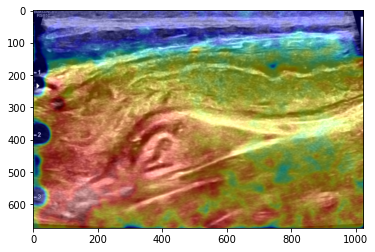

In [84]:
plt.imshow(compose_overlay[21])

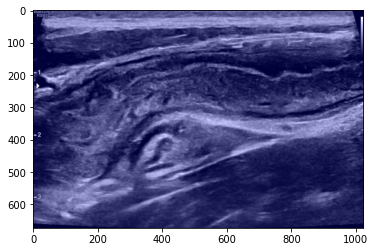

In [36]:
plt.imshow(compose_overlay[7])

In [86]:
flow_overlay = np.zeros((*us_data.shape, 4), dtype=np.uint8) # 4 8-bit channels: red, green, blue, and alpha
flow_magnitudes = np.zeros_like(us_data, dtype=np.float) # store the magnitudes as floating points for later processing

In [87]:
last_frame = None



colour_map = plt.get_cmap('jet') # use the 'jet' colour map just to map intensities onto colours

for current_frame, flow_frame, magnitude_frame in zip(us_data, flow_overlay, flow_magnitudes):
    if last_frame is not None:
        # calculate the cartesian flow vectors
        flow = cv2.calcOpticalFlowFarneback(last_frame, current_frame, None, 0.5, 5, 75, 3, 7, 1.5, cv2.OPTFLOW_FARNEBACK_GAUSSIAN)
        
        # calculate the magnitude and angle of the flow vectors
        mag, ang = cv2.cartToPolar(flow[...,0], flow[...,1])
        
        # calculate the normalised magnitude
        magnitude_frame[:] = cv2.normalize(mag, None, alpha=0., beta=1., norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_64F)
                
        # map the magnitude onto RGB colourspace
        flow_frame[...,:] = colour_map(magnitude_frame, alpha=1, bytes=True)
        
        # map the alpha channel to the magnitude squared
        flow_frame[...,3] = cv2.normalize(magnitude_frame**2, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
        
    last_frame = current_frame

In [5]:
flow_overlay = np.zeros((*us_data.shape, 4), dtype=np.uint8) # 4 8-bit channels: red, green, blue, and alpha
flow_magnitudes = np.zeros_like(us_data, dtype=np.float) # store the magnitudes as floating points for later processing

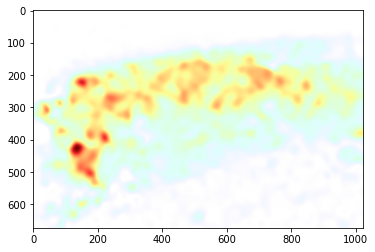

In [90]:
plt.imshow(flow_overlay[23])

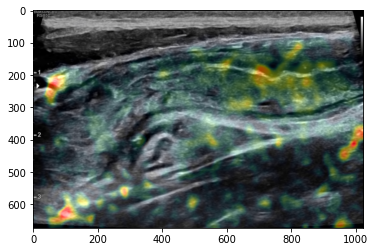

In [91]:
rgba_scan = np.zeros((*us_data.shape, 4), dtype=np.uint8) # we need an RGBA representation of the original scan
rgba_scan[...,0] = us_data[...]
rgba_scan[...,1] = us_data[...]
rgba_scan[...,2] = us_data[...]
rgba_scan[...,3] = 255 * np.ones_like(us_data)

flow_overlay_alph = apply_alpha(flow_overlay)

final_composition = np.zeros_like(rgba_scan, dtype=np.uint8)
final_composition[...] = cv2.add(rgba_scan, flow_overlay_alph)

plt.imshow(final_composition[22])

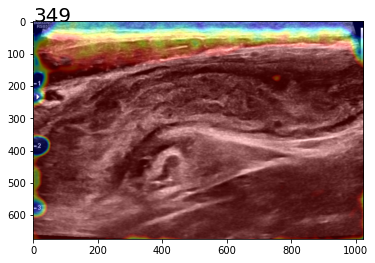

In [97]:
# Animate the 30 frames from window 469
import matplotlib.pyplot as plt
from matplotlib import animation 
import numpy as np

ims = []
fig = plt.figure()
ax = fig.add_subplot(111)

for img_num in range(250, 350,1): #random image for an example
    frame =  ax.imshow(us_data[img_num])   
    t = ax.annotate(img_num,(1,1), size = 20) # add text
    ims.append([frame,t]) # add both the image and the text to the list of artists 

anim = animation.ArtistAnimation(fig, ims, interval=100)
anim.save('./overlay.gif', writer='pillow')

plt.show()

### Steadiness score using a specific reference frame  



#### Calculate standard deviation between reference frame (frame 250) and all other frames


##### A function that requires an input of a reference frame, will calculate standard deviation between reference frame and all the other frames

In [656]:
def sd_ref(pixel_data, ref_index):
    
    # store sum of squared = sum of difference between pixel values squared
    sum_squared = []
    sd = []
    
    # Number of frame - 1
    N = pixel_data.shape[0] - 1
    
    # Reference frame that is used to compare with other frames
    ref = pixel_data[ref_index]
    
    for frame in pixel_data:
        sum_squared.append(np.sum(np.square(np.subtract(ref,frame))))
        
    for frame in sum_squared:
        sd.append(np.sqrt(np.divide(frame, N)))
    return sd

In [673]:
# Calculate standard deviations between frame 250 and all other frames
sd_ref1 = sd_ref(us_data, 250)

<BarContainer object of 558 artists>

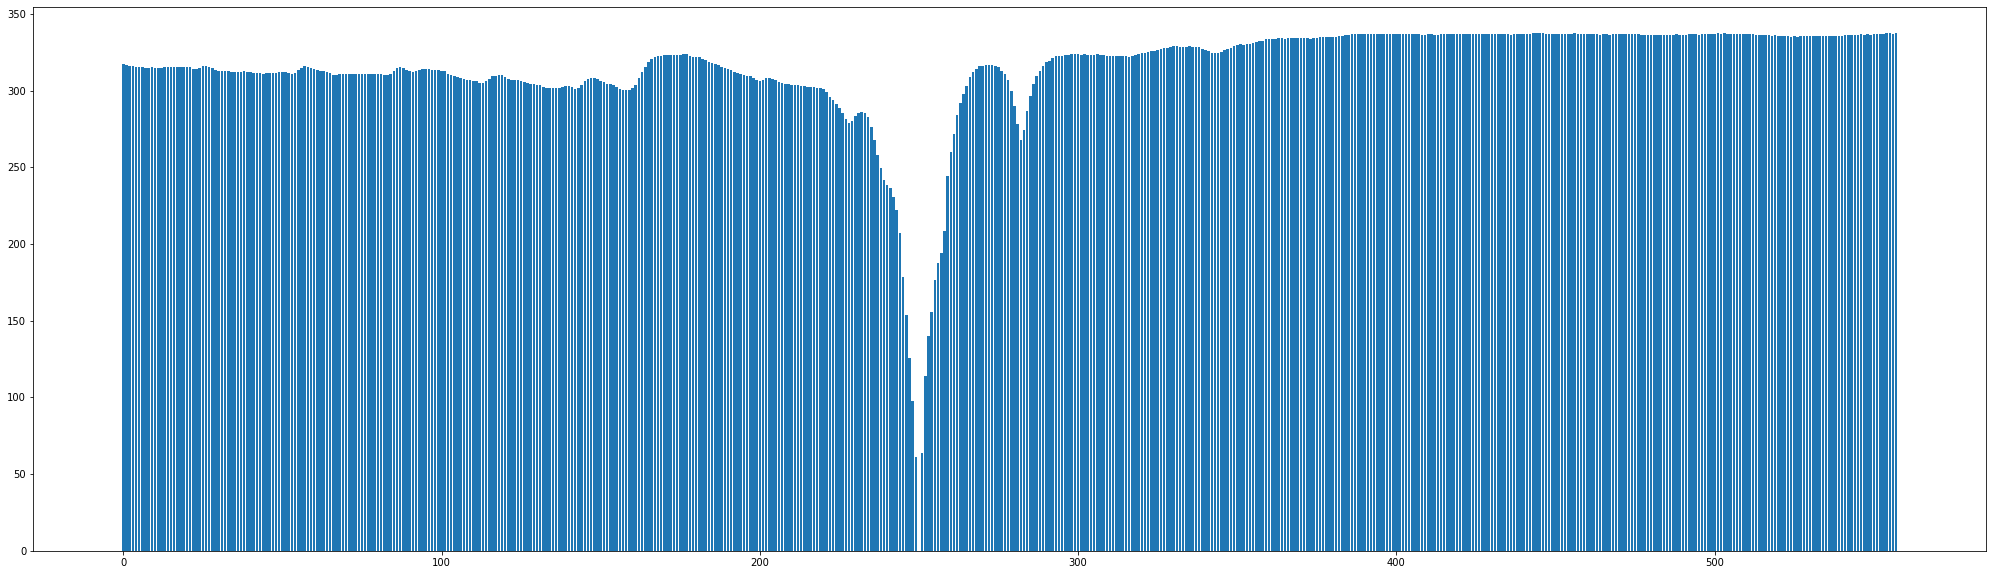

In [674]:
# Plot standard deviation for each frame
fig = plt.figure()
fig.set_size_inches(35, 10)
plt.bar(range(0, len(sd_ref1),1), sd_ref1)

# 
# 

## Week 2: May 24th
#### Build on steadiness score, using average frame as the reference
### Calculate standard deviation from the mean for each frame (sd_ref_mean)
##### Instead of defining a reference frame, I generated a "mean frame" by averaging pixel values from all frames, then calculate standard deviations between the mean frame and each frame

In [26]:
# Generate a "mean frame" by averaging pixel values from all frames
mean = us_data.mean(axis=0)
mean

array([[177., 177., 177., ...,   0.,   0.,   0.],
       [178., 178., 178., ...,   0.,   0.,   0.],
       [174., 190., 169., ...,   0.,   0.,   0.],
       ...,
       [  0.,   0.,   0., ...,   0.,   0.,   0.],
       [  0.,   0.,   0., ...,   0.,   0.,   0.],
       [  0.,   0.,   0., ...,   0.,   0.,   0.]])

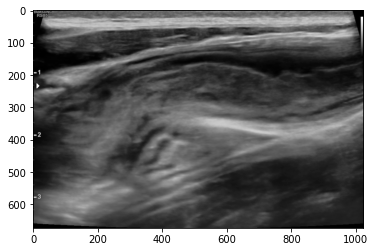

In [31]:
plt.imshow(mean, cmap = "Greys_r")

In [27]:
mean.shape

(674, 1024)

In [14]:
us_data[0].shape

(674, 1024)

In [76]:
# A function that outputs the standard deviation from the mean frame to all the other frames

def SD(pixel_data):
    
    # Calculate mean pixel values across all frames, this is used as the "reference frame"
    mean = pixel_data.mean(axis=0)
    
    # store sum of squared = sum of difference between pixel values squared
    sum_squared = []
    sd = []
    
    # Number of frame - 1
    N = pixel_data.shape[0] - 1
    
    # For each frame, calculate the sum of squared error between pixel values of the mean and the frame
    for frame in pixel_data:
        sum_squared.append(np.sum(np.square(np.subtract(frame, mean))))
    
    # For each frame, calculate the standard deviation using SSE between pixel values of the mean and the frame
    for frame in sum_squared:
        sd.append(np.sqrt(np.divide(frame, N)))
    return sd

In [77]:
sd_ref_mean = SD(us_data)

<BarContainer object of 558 artists>

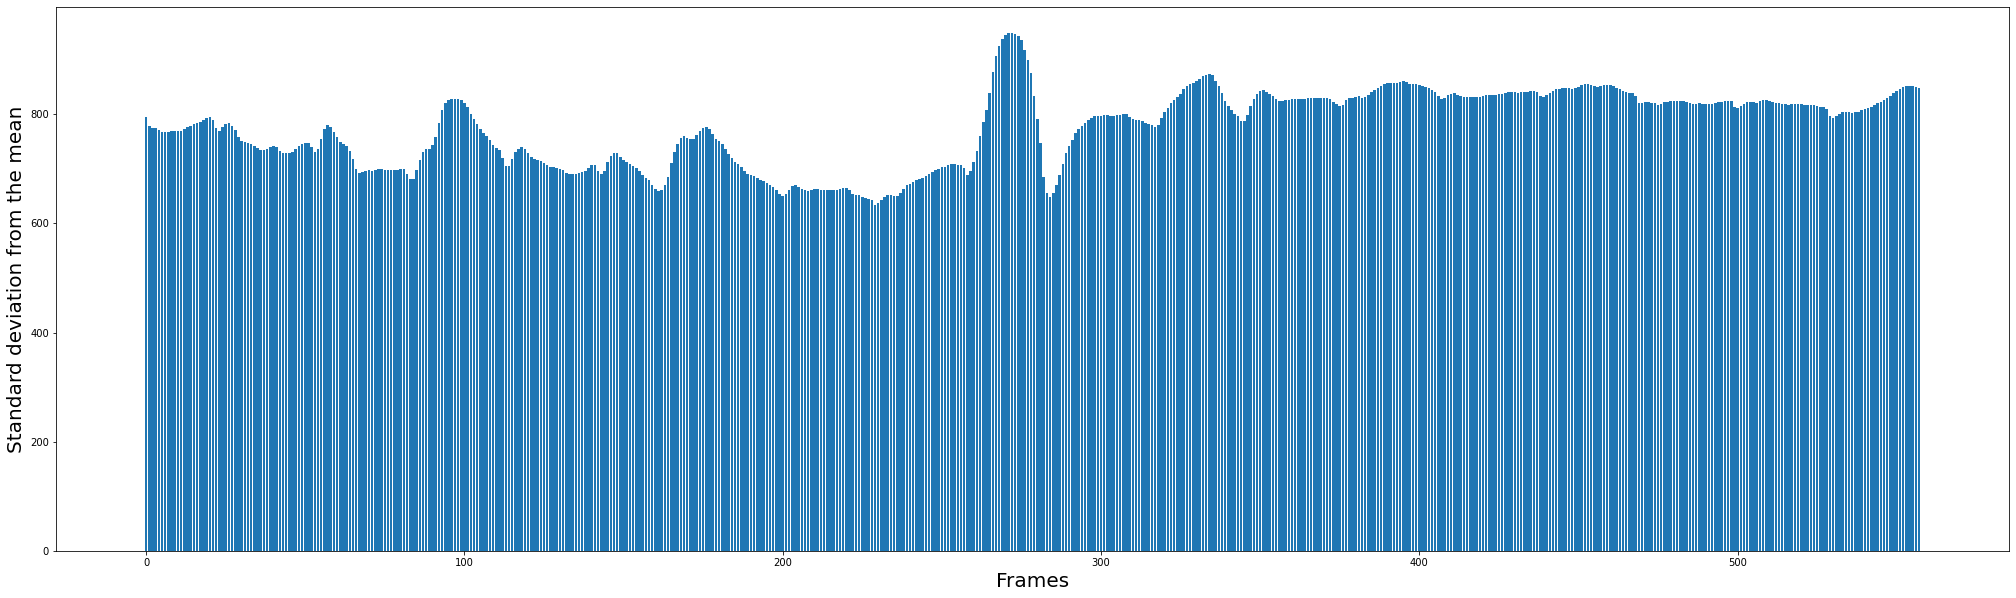

In [78]:
# Visualise on plot
fig = plt.figure()
fig.set_size_inches(35, 10)
plt.ylabel("Standard deviation from the mean", size = 20)
plt.xlabel("Frame Number", size = 20)
plt.xlabel("Frames")
plt.bar(range(0, len(sd_ref_mean),1), sd_ref_mean)

# 

### Add a sliding window of 10 to find a group of 10 frames that has the smallest standard deviation of sd_ref_mean (standard deviation from the mean frame)

#### Window 209 (frame 209 - 218) has the lowest standard deviation (SD = 0.61)

In [79]:
# Size of each window, eg. 10 = 10 frames per window 
window_size = 10

# Store sd_ref_mean values for each frame, grouped by windows
srm_per_window = []

# Store the mean values of sd_ref_mean for each window 
mean_per_window = []

# Store the standard deviations of sd_ref_mean for each window
sd_per_window = []



for i in range(len(sd_ref_mean)- window_size):
    window = sd_ref_mean[i:i + window_size]
    srm_per_window.append(sd_ref_mean[i:i + window_size])
    mean_per_window.append(np.mean(window))
    sd_per_window.append(np.std(window))

    
# Print out window index that has the smallest standard deviation 
index_min = min(range(len(sd_per_window)), key=sd_per_window.__getitem__)
print("The window index that yields the lowest standard deviation: %s" %str(index_min))
print()
print("The standard deviation for this window is: %s" %(sd_per_window[index_min]))



The window index that yields the lowest standard deviation: 209

The standard deviation for this window is: 0.6130338703745553


In [29]:
# Display sd_ref_mean values for 10 frames from that particular window (209)

x = srm_per_window[index_min]
print(x)

[661.6232711578612, 662.5680094543378, 663.2258381386428, 661.6481448271254, 661.3531841113787, 662.1422159100299, 662.170071951981, 662.2259712129061, 661.9917138687457, 663.283116625015]


In [30]:
# Extract the frame index of the first and last frame of the particular window (209)

x = srm_per_window[index_min]
print("Start frame: %s" %(sd_ref_mean.index(x[0])))
print("End frame: %s" %(sd_ref_mean.index(x[9])))

Start frame: 209
End frame: 218


## 

## Visualise 10-frame window in motion

### -  10-frame window with the lowest standard deviation: frame 209 - 218

#### Annotate window 209 on the plot (between the two red lines)

Text(0.5, 0, 'Frame Number')

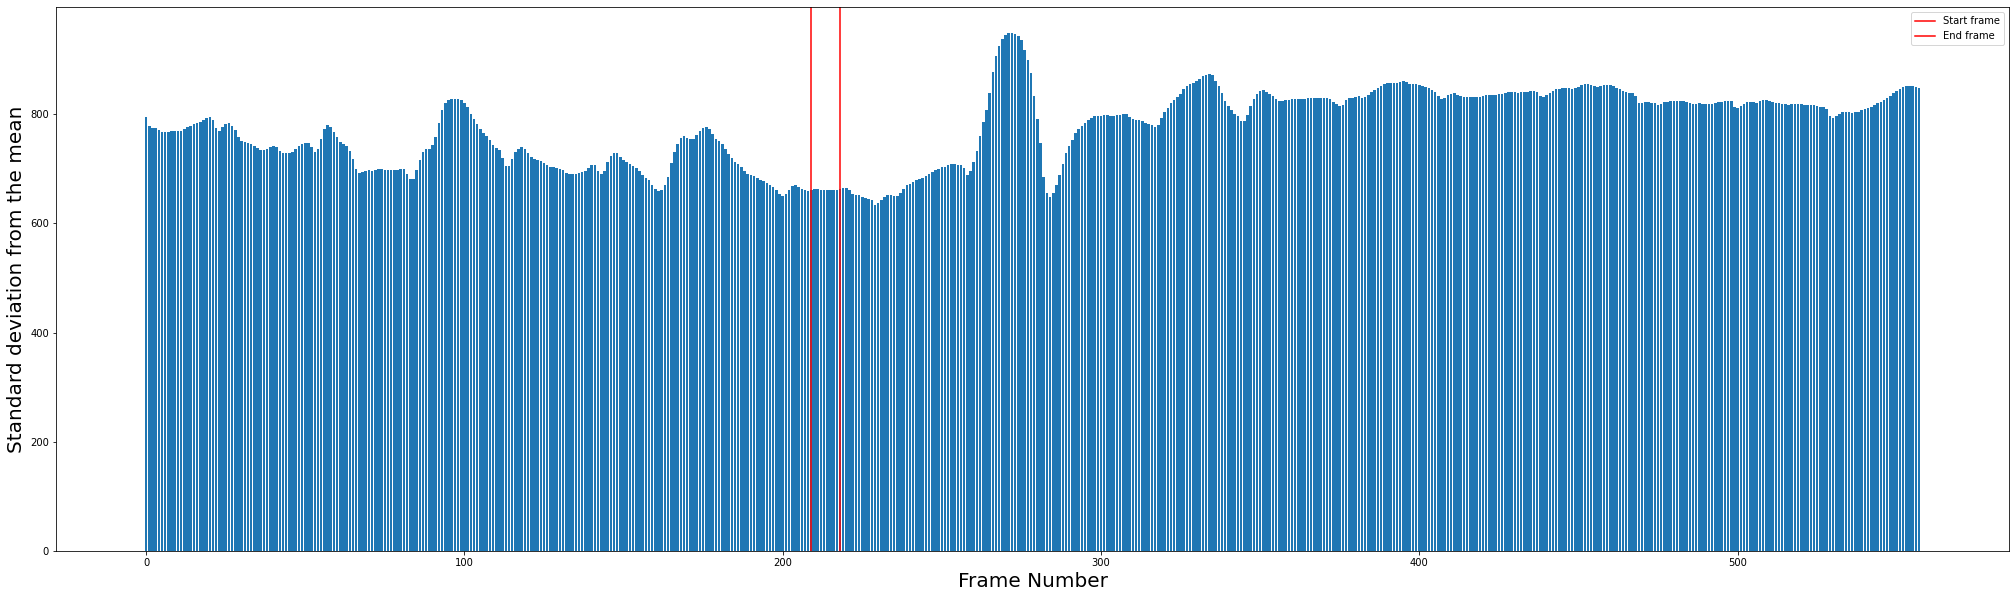

In [586]:
fig = plt.figure()
fig.set_size_inches(35, 10)
plt.bar(range(0, len(sd_ref_mean),1), sd_ref_mean)
plt.axvline(x=209, ymin=0, ymax= 900, color='red', label='Start frame')
plt.axvline(x=218, ymin=0, ymax= 900, color='red', label='End frame')
plt.legend()
plt.ylabel("Standard deviation from the mean", size = 20)
plt.xlabel("Frame Number", size = 20)


#### Animate the 10 frames from window 209 

/Users/angie/miniconda3/lib/python3.7/site-packages/matplotlib/animation.py:974: UserWarning: Animation was deleted without rendering anything. This is most likely unintended. To prevent deletion, assign the Animation to a variable that exists for as long as you need the Animation.
  'Animation was deleted without rendering anything. This is '


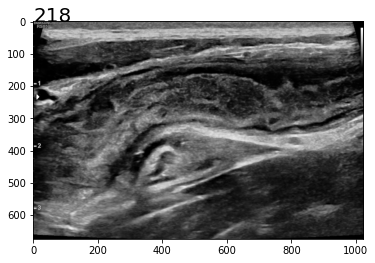

In [574]:
# Animate the 10 frames from window 209
import matplotlib.pyplot as plt
from matplotlib import animation 
import numpy as np

ims = []
fig = plt.figure()
ax = fig.add_subplot(111)

for img_num in range(209, 219,1): #random image for an example
    frame =  ax.imshow(us_data[img_num], cmap = "Greys_r")   
    t = ax.annotate(img_num,(1,1), size = 20) # add text
    ims.append([frame,t]) # add both the image and the text to the list of artists 

anim = animation.ArtistAnimation(fig, ims, interval=350)
#anim.save('./sd_min.gif', writer='pillow')

plt.show()


![SegmentLocal](sd_min.gif "us_data_10_frames_sdmin")

#### The 10 frames look quite steady to me, very limited motion
###### *Frame number on the top left corner
# 

### 10-frame window with the highest standard deviation: frame 275 - 284

In [580]:
# Extract the window that has the highest standard deviation
index_max = max(range(len(sd_per_window)), key=sd_per_window.__getitem__)
print("The window index that yields the highest standard deviation: %s" %str(index_max))
print()
print("The standard deviation for this window: %s" %(sd_window[index_max]))


The window index that yields the highest standard deviation: 275

The standard deviation for this window: 104.49305894562903


Text(0.5, 0, 'Frame Number')

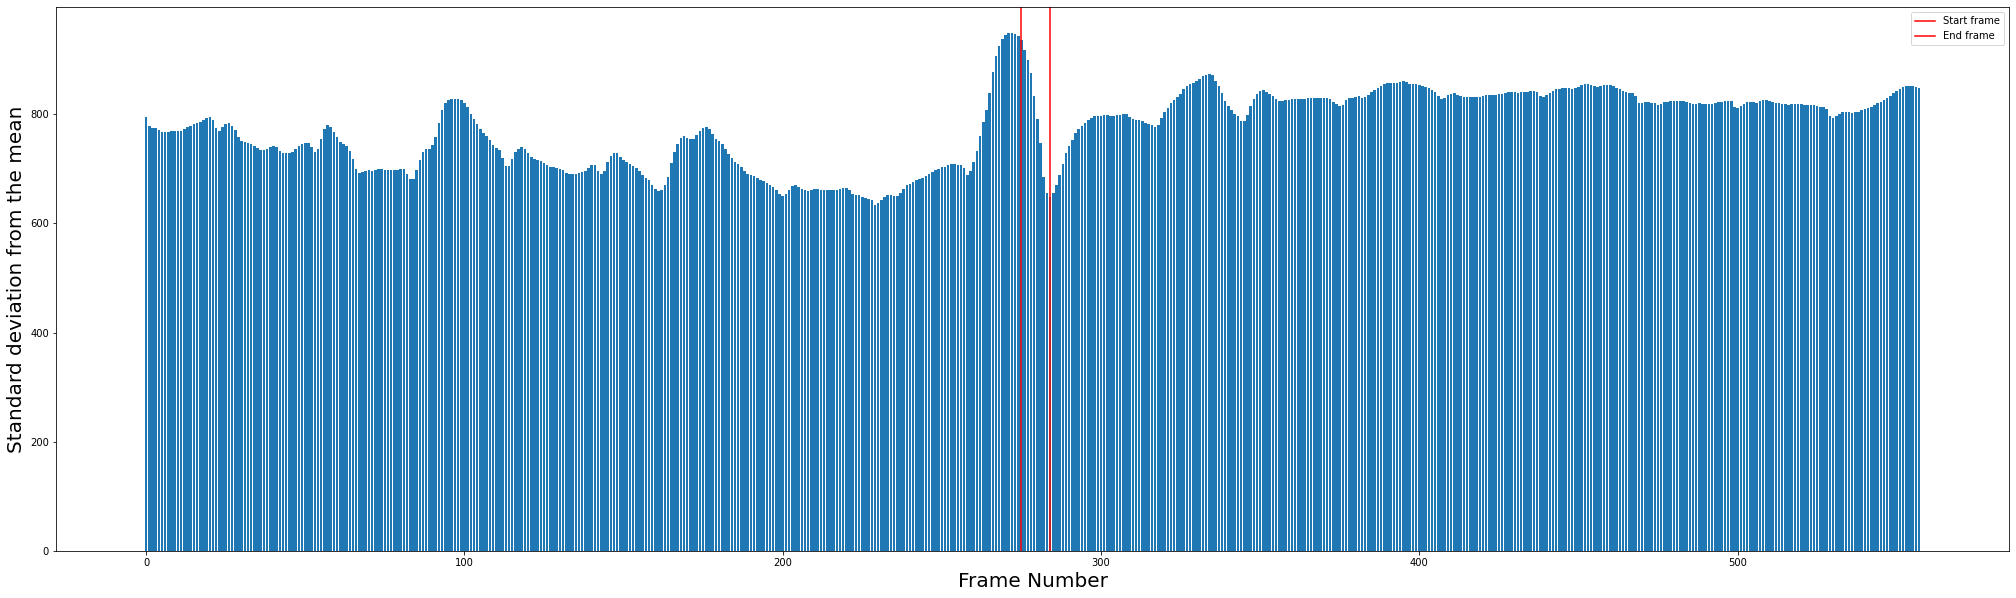

In [675]:
fig = plt.figure()
fig.set_size_inches(35, 10)
plt.bar(range(0, len(sd_ref_mean),1), sd_ref_mean)
plt.axvline(x=275, ymin=0, ymax= 900, color='red', label='Start frame')
plt.axvline(x=284, ymin=0, ymax= 900, color='red', label='End frame')
plt.legend()
plt.ylabel("Standard deviation from the mean", size = 20)
plt.xlabel("Frame Number", size = 20)

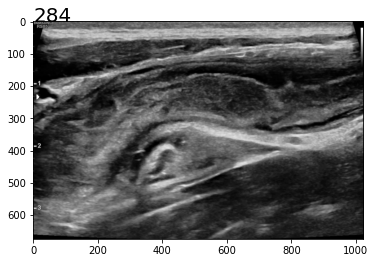

In [575]:
# Animate the 10 frames from window 275
import matplotlib.pyplot as plt
from matplotlib import animation 
import numpy as np

ims = []
fig = plt.figure()
ax = fig.add_subplot(111)

for img_num in range(275, 285,1): #random image for an example
    frame =  ax.imshow(us_data[img_num], cmap = "Greys_r")   
    t = ax.annotate(img_num,(1,1), size = 20) # add text
    ims.append([frame,t]) # add both the image and the text to the list of artists 

anim = animation.ArtistAnimation(fig, ims, interval=350)
#anim.save('./sd_max.gif', writer='pillow')

plt.show()


![SegmentLocal](sd_max.gif "us_data_10_frames_sdmax")

### Investigate long-term steadiness - window size = 30

##### In this ultrasound file, with window size larger than 21 frames (all the way to winsize of 60), window 469 has the lowest standard deviation
#### Window 469 (469 - 498)

In [642]:
# Size of each window, eg. 10 = 10 frames per window 
window_size = 30

# Store sd_ref_mean values for each frame, grouped by windows
srm_per_window = []

# Store the mean values of SSE for each window 
mean_per_window = []

# Store the standard deviations of sd_ref_mean for each window
sd_per_window = []



for i in range(len(sd_ref_mean)- window_size):
    window = sd_ref_mean[i:i + window_size]
    srm_per_window.append(sd_ref_mean[i:i + window_size])
    mean_per_window.append(np.mean(window))
    sd_per_window.append(np.std(window))

    
# Print out window index that has the smallest standard deviation 
index_min = min(range(len(sd_per_window)), key=sd_per_window.__getitem__)
print("The window index that yields the lowest standard deviation: %s" %str(index_min))
print()
print("The standard deviation for this window is: %s" %(sd_per_window[index_min]))




The window index that yields the lowest standard deviation: 469

The standard deviation for this window is: 2.0865512115662948


Text(0.5, 0, 'Frame Number')

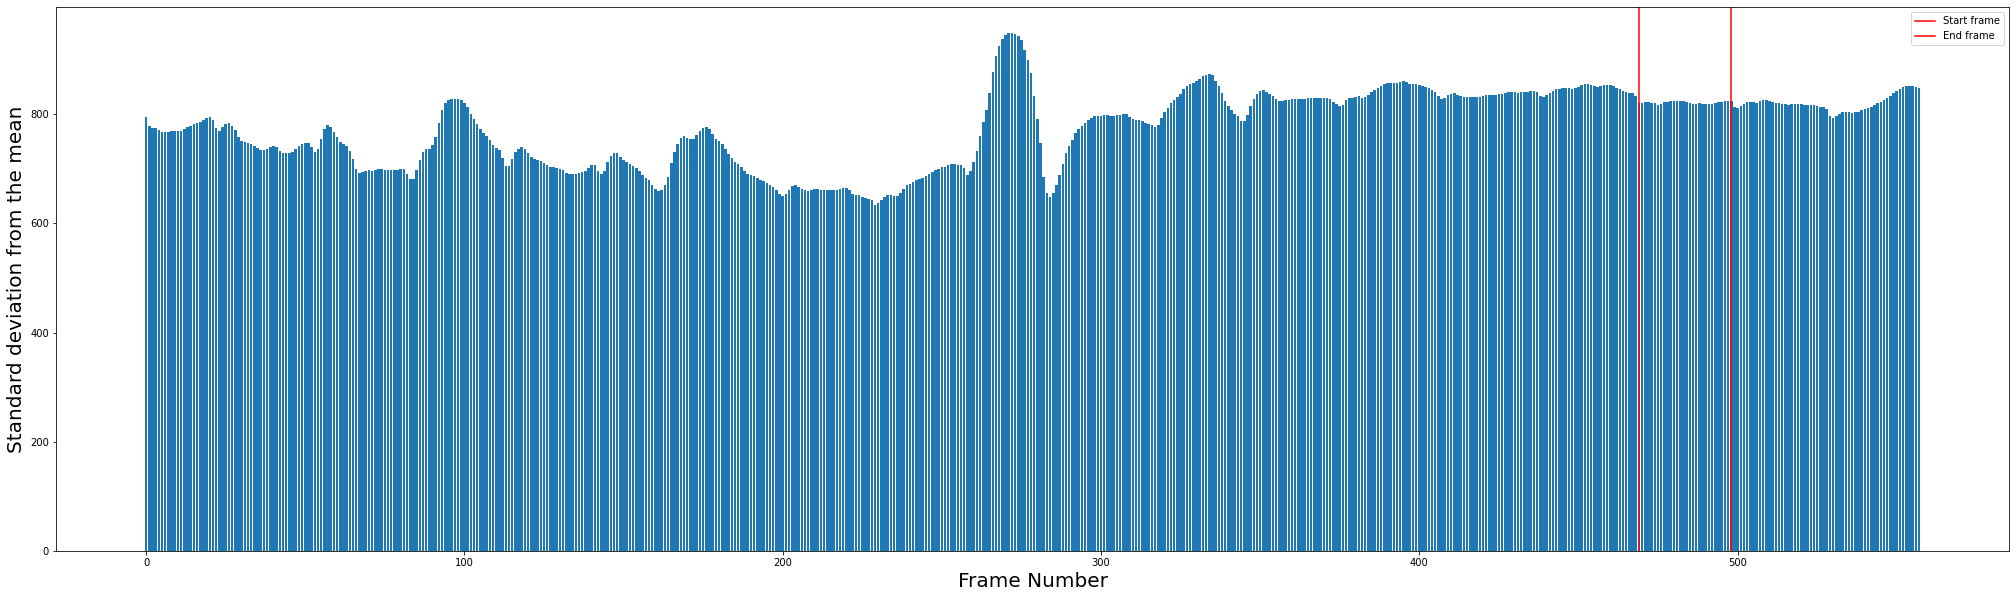

In [654]:
fig = plt.figure()
fig.set_size_inches(35, 10)
plt.bar(range(0, len(sd_ref_mean),1), sd_ref_mean)
plt.axvline(x=469, ymin=0, ymax= 900, color='red', label='Start frame')
plt.axvline(x=498, ymin=0, ymax= 900, color='red', label='End frame')
plt.legend()
plt.ylabel("Standard deviation from the mean", size = 20)
plt.xlabel("Frame Number", size = 20)

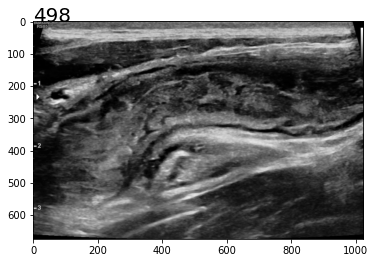

In [34]:
# Animate the 30 frames from window 469
import matplotlib.pyplot as plt
from matplotlib import animation 
import numpy as np

ims = []
fig = plt.figure()
ax = fig.add_subplot(111)

for img_num in range(469, 499,1): #random image for an example
    frame =  ax.imshow(us_data[img_num], cmap = "Greys_r")   
    t = ax.annotate(img_num,(1,1), size = 20) # add text
    ims.append([frame,t]) # add both the image and the text to the list of artists 

anim = animation.ArtistAnimation(fig, ims, interval=350)
anim.save('./sd_30f.gif', writer='pillow')

plt.show()


![SegmentLocal](sd_30f.gif "us_data_30frames_sdmin")

##### Steadiness sustained for a longer duration of time (30 frames)

# 
# 
# 
# 

# Week 3 - May 25th

## Task 1: Use reference windows instead of a specific reference frame

##### To calculate the difference bewteen reference window and each frame, I attempted to substract pixel values of frame by mean pixel values of each reference window. Due to having 500+ reference windows, this operation was halted automatically by my computer...
 
##### This is why I calculate a mean for each frame first then substract mean of each reference window (size 10)

In [6]:
# Create mean pixel values for each frame
mean_per_frame = []
for frame in us_data:
    x = np.mean(frame)
    mean_per_frame.append(x)
    #print(mean_per_frame)

mean_per_frame



[62.51959210404303,
 62.27704237759644,
 63.01357769612389,
 63.2599250046365,
 63.353679351353854,
 63.35227825945846,
 63.326137101261125,
 63.29725461331602,
 63.2814731314911,
 63.248294637889465,
 63.223387947422104,
 63.2091437546365,
 63.18800277030786,
 63.16774706741469,
 63.15396072885757,
 63.13121725472923,
 63.12576357334941,
 63.12489857659496,
 63.12763411071958,
 63.08997849823813,
 63.04730242720697,
 63.06673225380193,
 63.23813201270401,
 63.330850391784125,
 63.299075887889465,
 63.25259643916914,
 63.195990587908014,
 63.14331272023368,
 63.05906174656899,
 62.94765393175074,
 62.84932683837166,
 62.74602854923961,
 62.64412265856825,
 62.58228046179525,
 62.54687065328264,
 62.51436734977745,
 62.467493798683236,
 62.419887101261125,
 62.36838139836795,
 62.309242859792285,
 62.25966130378338,
 62.22364875046365,
 62.205357763816764,
 62.19944767711424,
 62.195043003523736,
 62.18703779905415,
 62.18050902958086,
 62.138709546550444,
 62.10544991422478,
 62.061329

In [13]:
# Create reference windows with a size of 10

# Size of each window, eg. 10 = 10 frames per window 
win_size = 10

# Store mean(reference windows)
reference_window = []

# Store the standard deviations of sd_ref_mean for each window
win_info = []

for i in range(len(mean_per_frame)- win_size):
    win = mean_per_frame[i:i + win_size]
    win_info.append(mean_per_frame[i:i + win_size])
    reference_window.append(np.mean(win))
    #print(mean_per_win)




In [14]:
reference_window

[63.09292542771699,
 63.1633050120549,
 63.25651514975889,
 63.2739576571773,
 63.26473986345511,
 63.244768001205486,
 63.22266190073257,
 63.2026245479414,
 63.1853889442693,
 63.17000504219213,
 63.154173428227,
 63.13656487620549,
 63.12232372612203,
 63.12733665036164,
 63.143646982798586,
 63.15815849870178,
 63.170296417145764,
 63.17731911860163,
 63.1791605329655,
 63.172303296550446,
 63.15807083990171,
 63.13827328101818,
 63.106202910561954,
 63.046801975148355,
 62.97194498214948,
 62.8967244586888,
 62.82290154974963,
 62.75005187082714,
 62.67770930892989,
 62.6086412741098,
 62.54480016691396,
 62.48583361345512,
 62.433595633577525,
 62.38971914410238,
 62.351435865634265,
 62.316253100658386,
 62.28352014558605,
 62.25482166867581,
 62.226703913204744,
 62.20041076479043,
 62.175619407223664,
 62.15406519496476,
 62.136232352327525,
 62.133035776381675,
 62.155839090319,
 62.19218952846811,
 62.228819025871665,
 62.264148130331975,
 62.30364066556937,
 62.347952985905

In [139]:
### NOT FEASIBLE TO CALCULATE PIXELS BY PIXELS, NEED TO CONVERT TO MEAN PER FRAME FIRST
reference_window = []

for i in range(len(us_data)- win_size):
    win = us_data[i:i + win_size]
    print(win)
    win_info.append(us_data[i:i + win_size])
    reference_window.append(win.mean(axis = 0))
    #print(mean_per_win)


In [189]:
#### Compute standard deviation between mean pixel values of each frame and each reference window

diff_squared = []
sd_ref_window =[]

N = len(reference_window) - 1

for window in reference_window:
    diff_squared.append(np.square(mean_per_frame - window))

for i in diff_squared:
    sd_ref_window.append(np.sqrt(np.divide(i, N)))


In [183]:
#### Compute standard deviation between mean pixel values of each frame and each reference window

diff_squared = []
sd_ref_window =[]

N = len(reference_window) - 1

for window in reference_window:
    sd_ref_window.append(np.square(mean_per_frame - window))

#for i in diff_squared:
    #sd_ref_window.append(np.sqrt(np.divide(i, N)))

In [184]:
sd_ref_window[0].shape

(558,)

### Visualise with defined reference window: 0, 100, 200, 300, 400, 500

##### To make sure it is working, we should see a sharp decrease on the position of the reference window, annotated by 2 blue lines. 
##### Window 0 has some movement to start with so when applying reference window 0 on the frame 0 - 10, the dip was not very obvious on the graph

![SegmentLocal](ok.gif "us_data_10_frames_sd_ref_win")

Text(0.5, 1.0, 'Reference window 0')

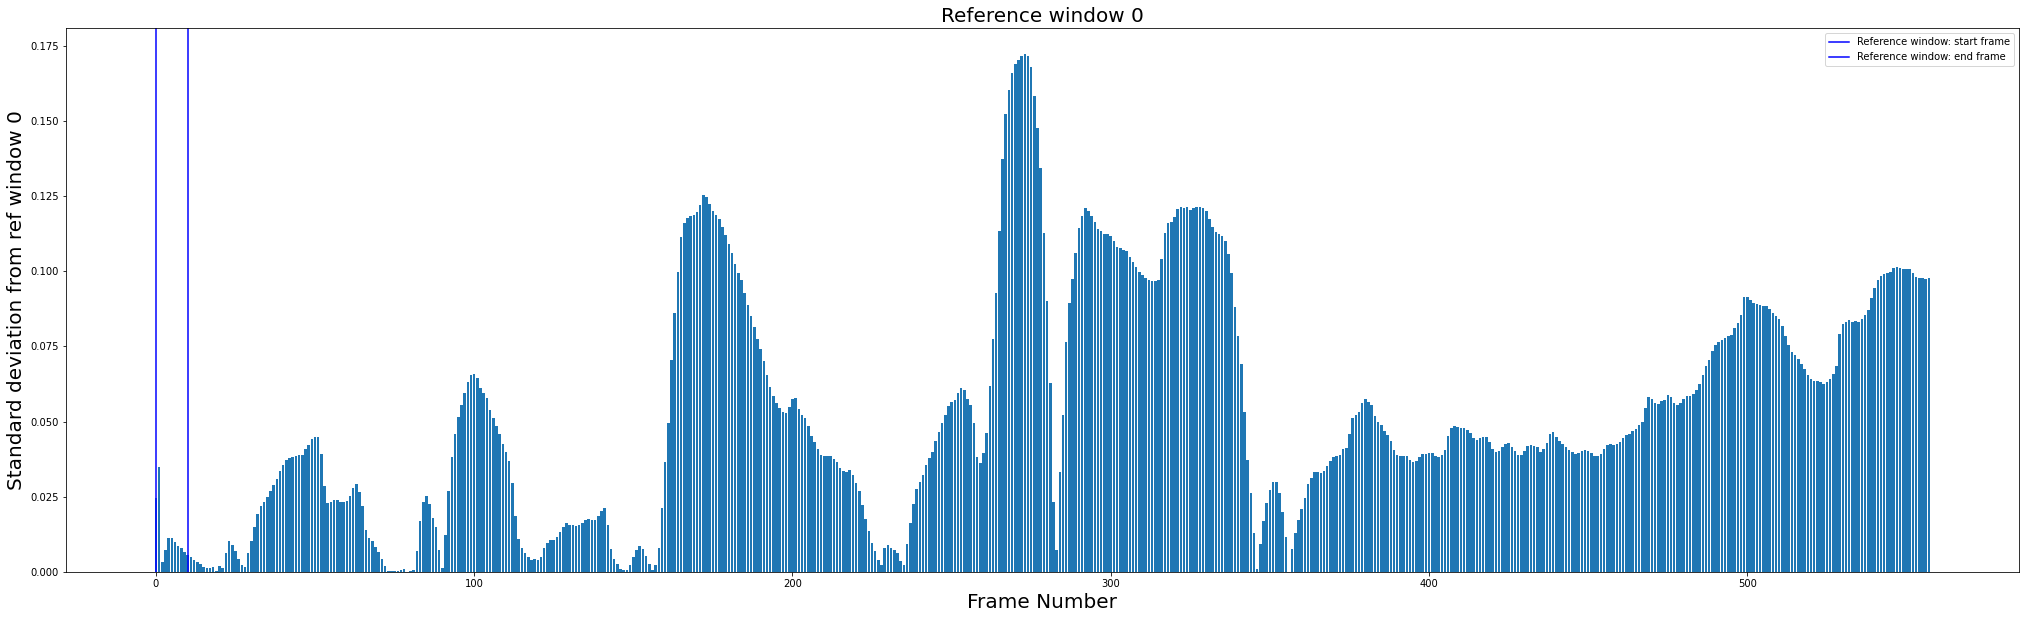

In [190]:
# Define the window index of the reference window you want to use
ref_win_index = 0
size = 10

fig = plt.figure()
fig.set_size_inches(35, 10)
plt.bar(range(0, len(us_data),1), sd_ref_window[ref_win_index])
plt.axvline(x=ref_win_index, ymin=0, ymax= 900, color='blue', label='Reference window: start frame')
plt.axvline(x=ref_win_index+10, ymin=0, ymax= 900, color='blue', label='Reference window: end frame')
plt.legend()
plt.ylabel("Standard deviation from ref window %s" %(ref_win_index), size = 20)
plt.xlabel("Frame Number", size = 20)
plt.title("Reference window %s" %(ref_win_index), size = 20)

Text(0.5, 1.0, 'Reference window 100')

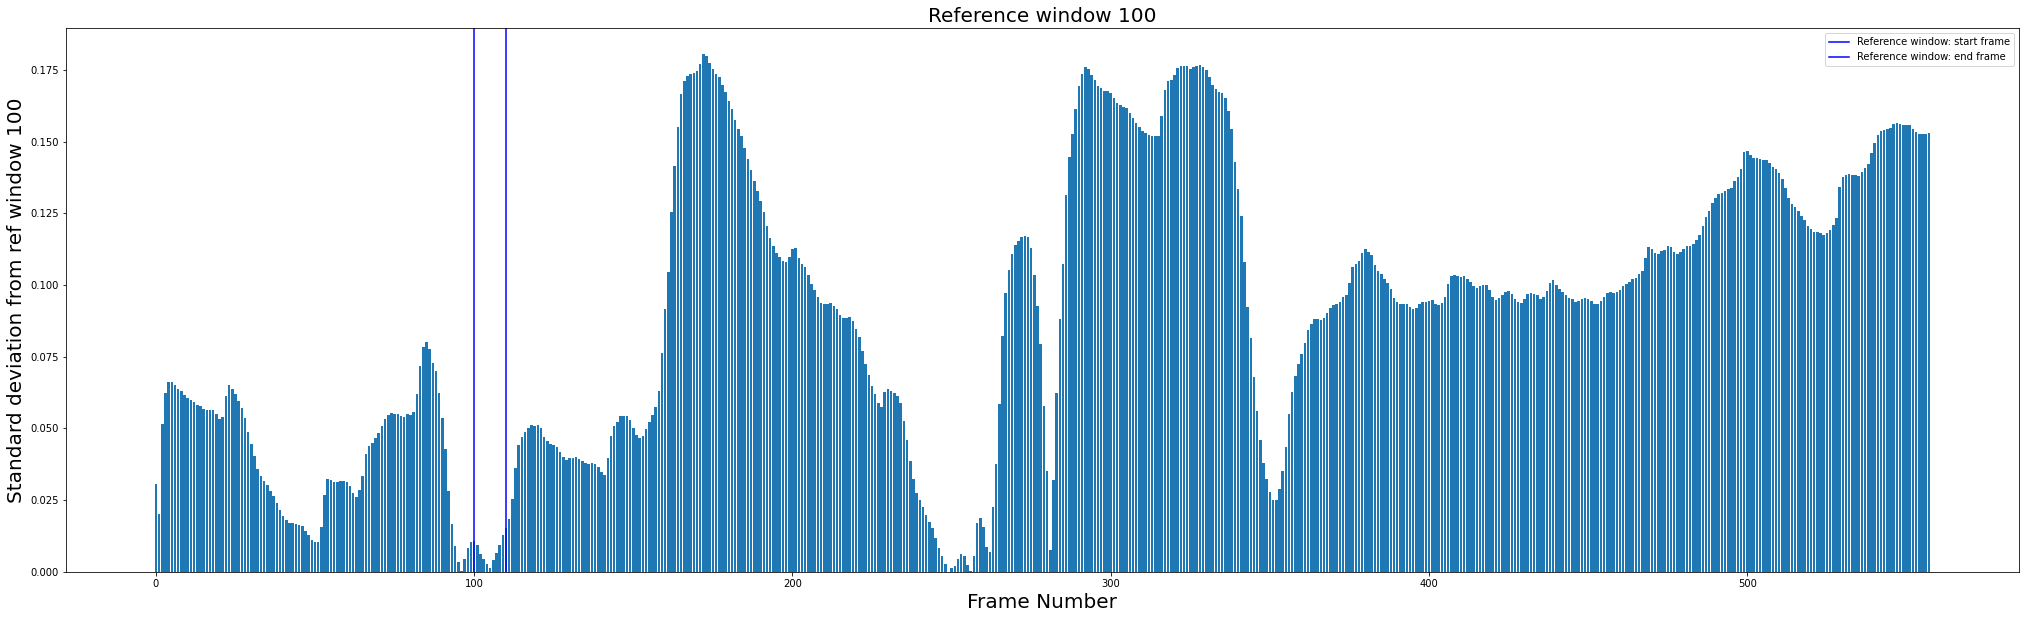

In [192]:
# Define the window index of the reference window you want to use
ref_win_index = 100
size = 10

fig = plt.figure()
fig.set_size_inches(35, 10)
plt.bar(range(0, len(us_data),1), sd_ref_window[ref_win_index])
plt.axvline(x=ref_win_index, ymin=0, ymax= 900, color='blue', label='Reference window: start frame')
plt.axvline(x=ref_win_index+10, ymin=0, ymax= 900, color='blue', label='Reference window: end frame')
plt.legend()
plt.ylabel("Standard deviation from ref window %s" %(ref_win_index), size = 20)
plt.xlabel("Frame Number", size = 20)
plt.title("Reference window %s" %(ref_win_index), size = 20)

Text(0.5, 1.0, 'Reference window 200')

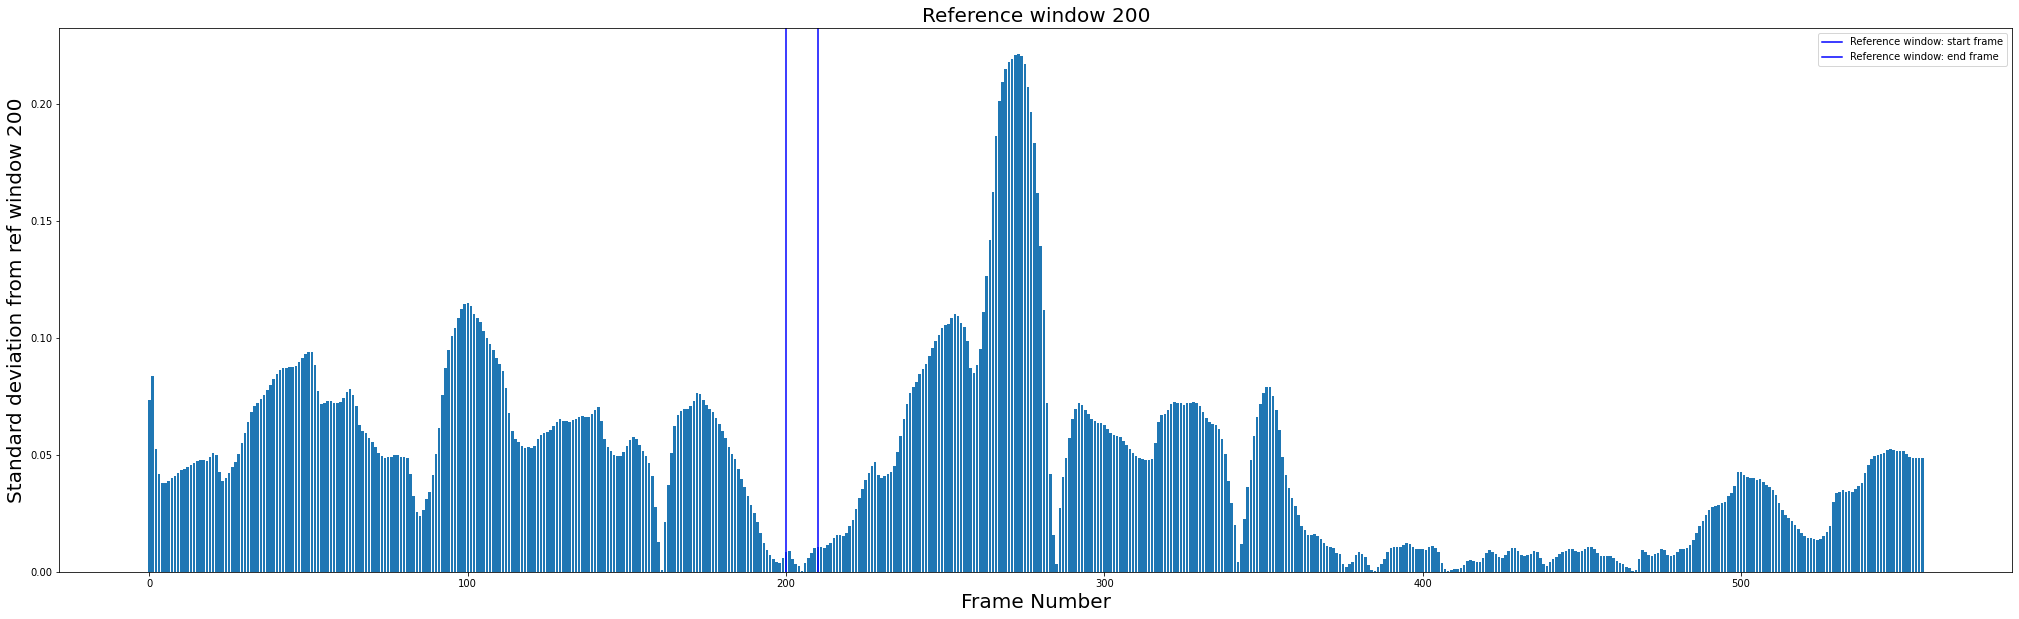

In [147]:
# Define the window index of the reference window you want to use
ref_win_index = 200
size = 10

fig = plt.figure()
fig.set_size_inches(35, 10)
plt.bar(range(0, len(us_data),1), sd_ref_window[ref_win_index])
plt.axvline(x=ref_win_index, ymin=0, ymax= 900, color='blue', label='Reference window: start frame')
plt.axvline(x=ref_win_index+10, ymin=0, ymax= 900, color='blue', label='Reference window: end frame')
plt.legend()
plt.ylabel("Standard deviation from ref window %s" %(ref_win_index), size = 20)
plt.xlabel("Frame Number", size = 20)
plt.title("Reference window %s" %(ref_win_index), size = 20)

Text(0.5, 1.0, 'Reference window 300')

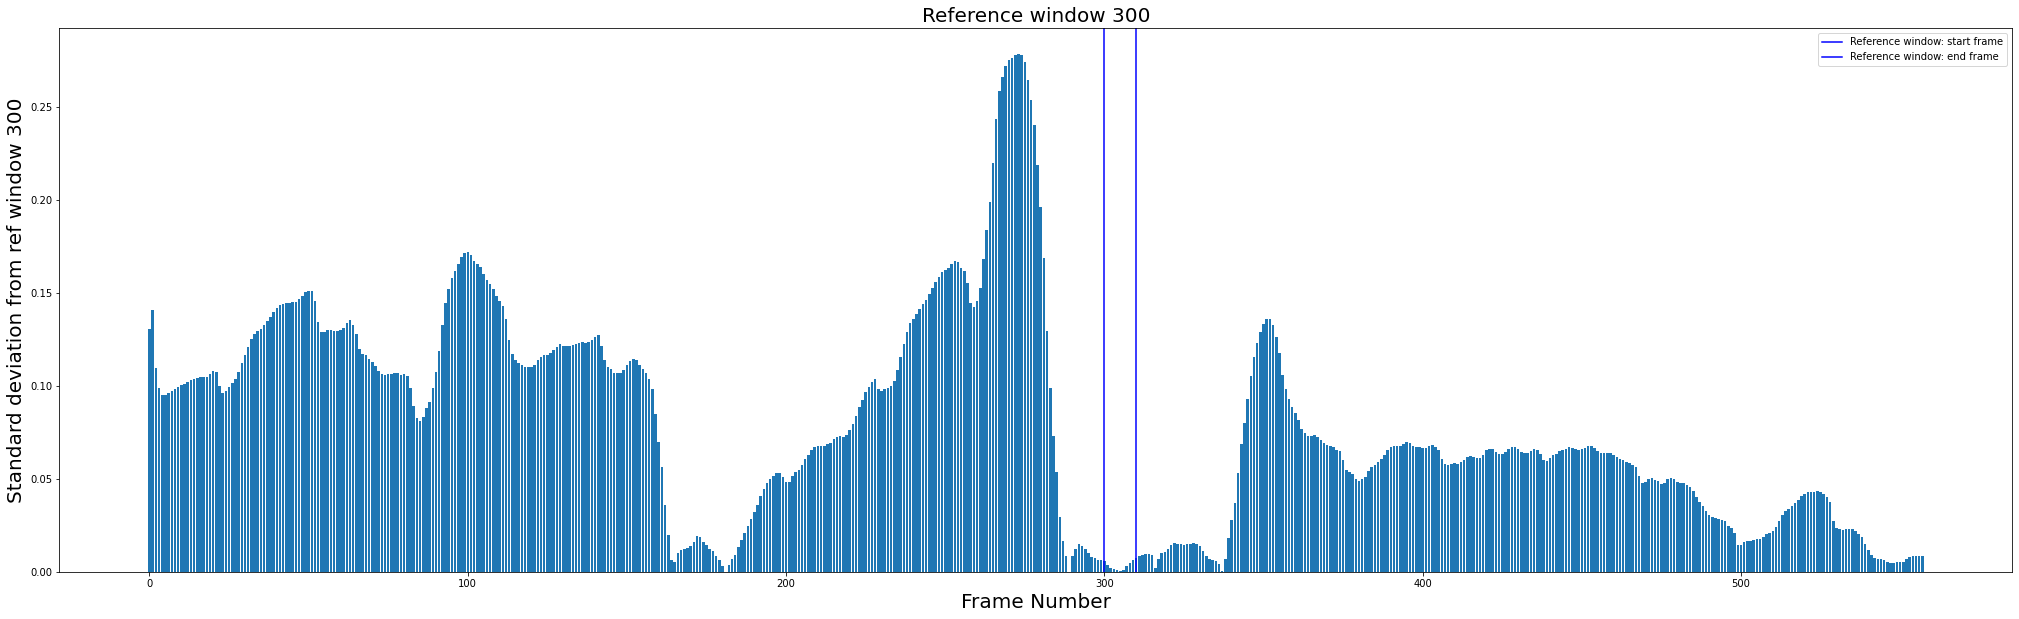

In [146]:
# Define the window index of the reference window you want to use
ref_win_index = 300
size = 10

fig = plt.figure()
fig.set_size_inches(35, 10)
plt.bar(range(0, len(us_data),1), sd_ref_window[ref_win_index])
plt.axvline(x=ref_win_index, ymin=0, ymax= 900, color='blue', label='Reference window: start frame')
plt.axvline(x=ref_win_index+10, ymin=0, ymax= 900, color='blue', label='Reference window: end frame')
plt.legend()
plt.ylabel("Standard deviation from ref window %s" %(ref_win_index), size = 20)
plt.xlabel("Frame Number", size = 20)
plt.title("Reference window %s" %(ref_win_index), size = 20)

Text(0.5, 1.0, 'Reference window 400')

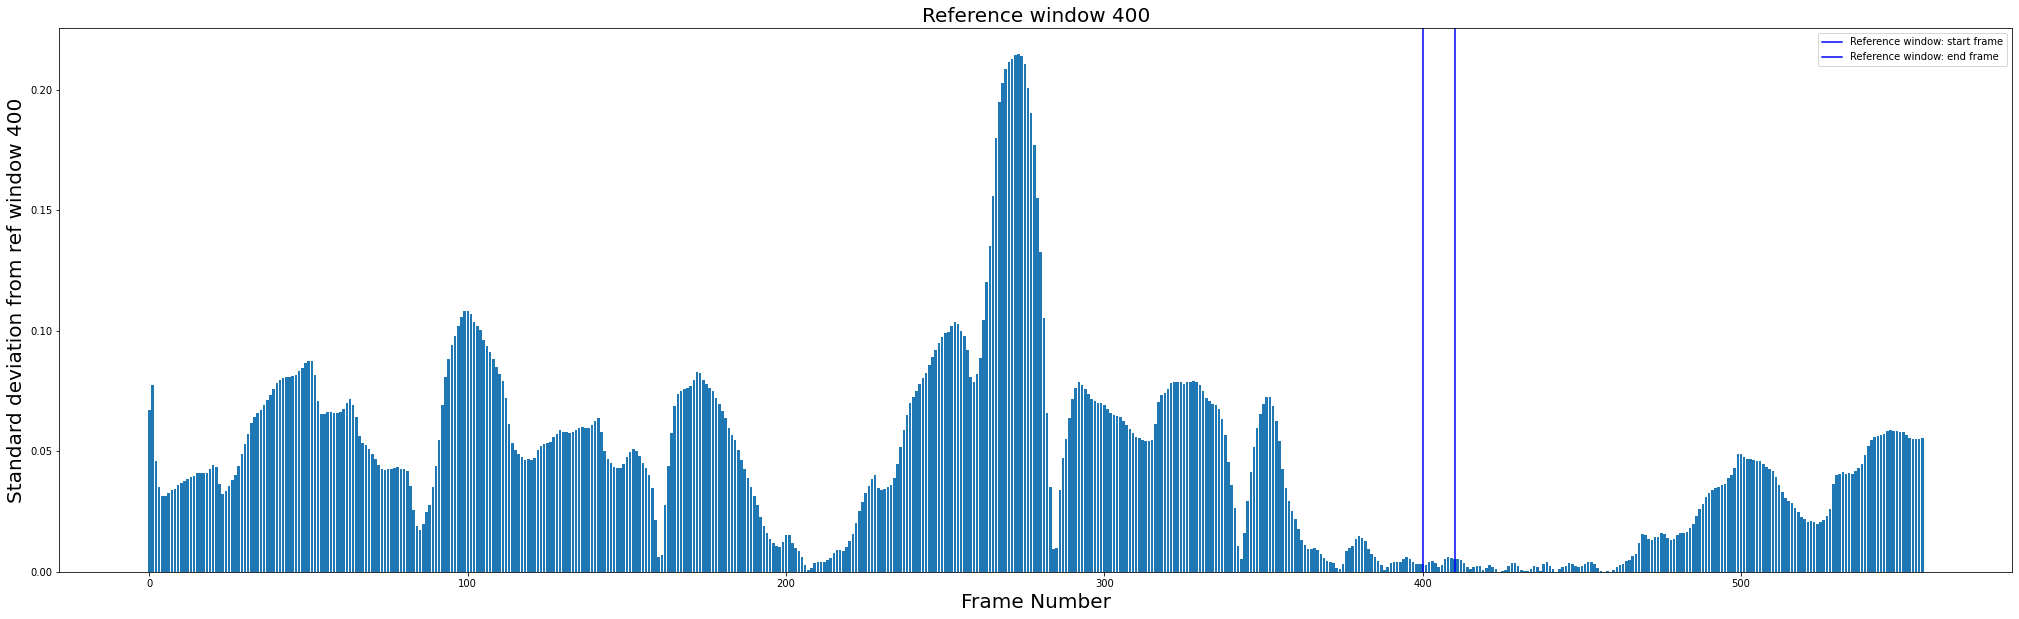

In [145]:
# Define the window index of the reference window you want to use
ref_win_index = 400
size = 10

fig = plt.figure()
fig.set_size_inches(35, 10)
plt.bar(range(0, len(us_data),1), sd_ref_window[ref_win_index])
plt.axvline(x=ref_win_index, ymin=0, ymax= 900, color='blue', label='Reference window: start frame')
plt.axvline(x=ref_win_index+10, ymin=0, ymax= 900, color='blue', label='Reference window: end frame')
plt.legend()
plt.ylabel("Standard deviation from ref window %s" %(ref_win_index), size = 20)
plt.xlabel("Frame Number", size = 20)
plt.title("Reference window %s" %(ref_win_index), size = 20)

Text(0.5, 1.0, 'Reference window 500')

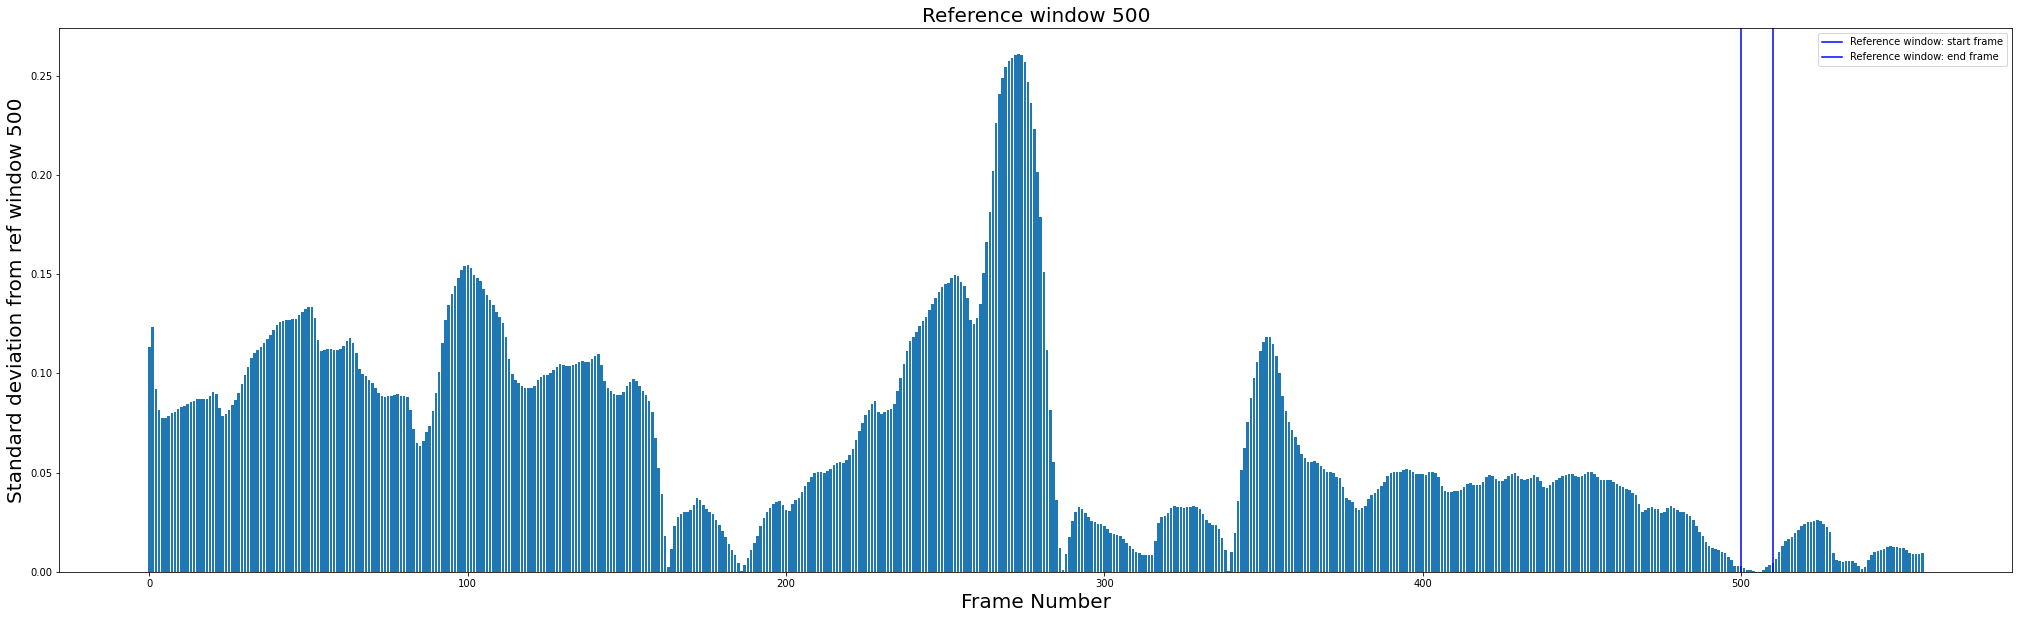

In [144]:
# Define the window index of the reference window you want to use
ref_win_index = 500
size = 10

fig = plt.figure()
fig.set_size_inches(35, 10)
plt.bar(range(0, len(us_data),1), sd_ref_window[ref_win_index])
plt.axvline(x=ref_win_index, ymin=0, ymax= 900, color='blue', label='Reference window: start frame')
plt.axvline(x=ref_win_index+10, ymin=0, ymax= 900, color='blue', label='Reference window: end frame')
plt.legend()
plt.ylabel("Standard deviation from ref window %s" %(ref_win_index), size = 20)
plt.xlabel("Frame Number", size = 20)
plt.title("Reference window %s" %(ref_win_index), size = 20)

### 
### Find the frame that yield the lowest standard deviation: 10 frame window

##### I tested for all 548 reference window, window 321 (highest occurence) and 73 (second highest) have the lowest standard deviation

#### Some general thoughts:
###### * Window 219, selected using average reference frame previously, has a bigger standard deviation here, hence not selected. The graph shows a steep slope at window 219 instead of a plateau observed previously.
###### * Conversely, window 321 selected here had a huge standard deviation in the graph using average reference frame.
###### * Visually speaking, both windows are very steady!

###### * Window 73 is consistent to the results using the "average reference frame" with a window size of size 8

In [77]:
# Size of each window, eg. 10 = 10 frames per window 
window_size = 10

# Define the reference window you want to use, using reference window 100 as an example
srw = sd_ref_window[100]

# Store sd_ref_mean values for each frame, grouped by windows
srw_per_win = []

# Store the mean values of SSE for each window 
mean_per_win = []

# Store the standard deviations of sd_ref_mean for each window
sd_per_win = []


for i in range(len(srw)- window_size):
    window = srw[i:i + window_size]
    srw_per_win.append(srw[i:i + window_size])
    sd_per_win.append(np.std(window))

# Print out window index that has the smallest standard deviation 
index_min = min(range(len(sd_per_win)), key=sd_per_win.__getitem__)
print("The window index that yields the lowest standard deviation: %s" %str(index_min))
print()
print("The standard deviation for this window is: %s" %(sd_per_win[index_min]))



The window index that yields the lowest standard deviation: 321

The standard deviation for this window is: 0.0004828277380178447


### Visualisation

Text(0.5, 1.0, 'Window 321')

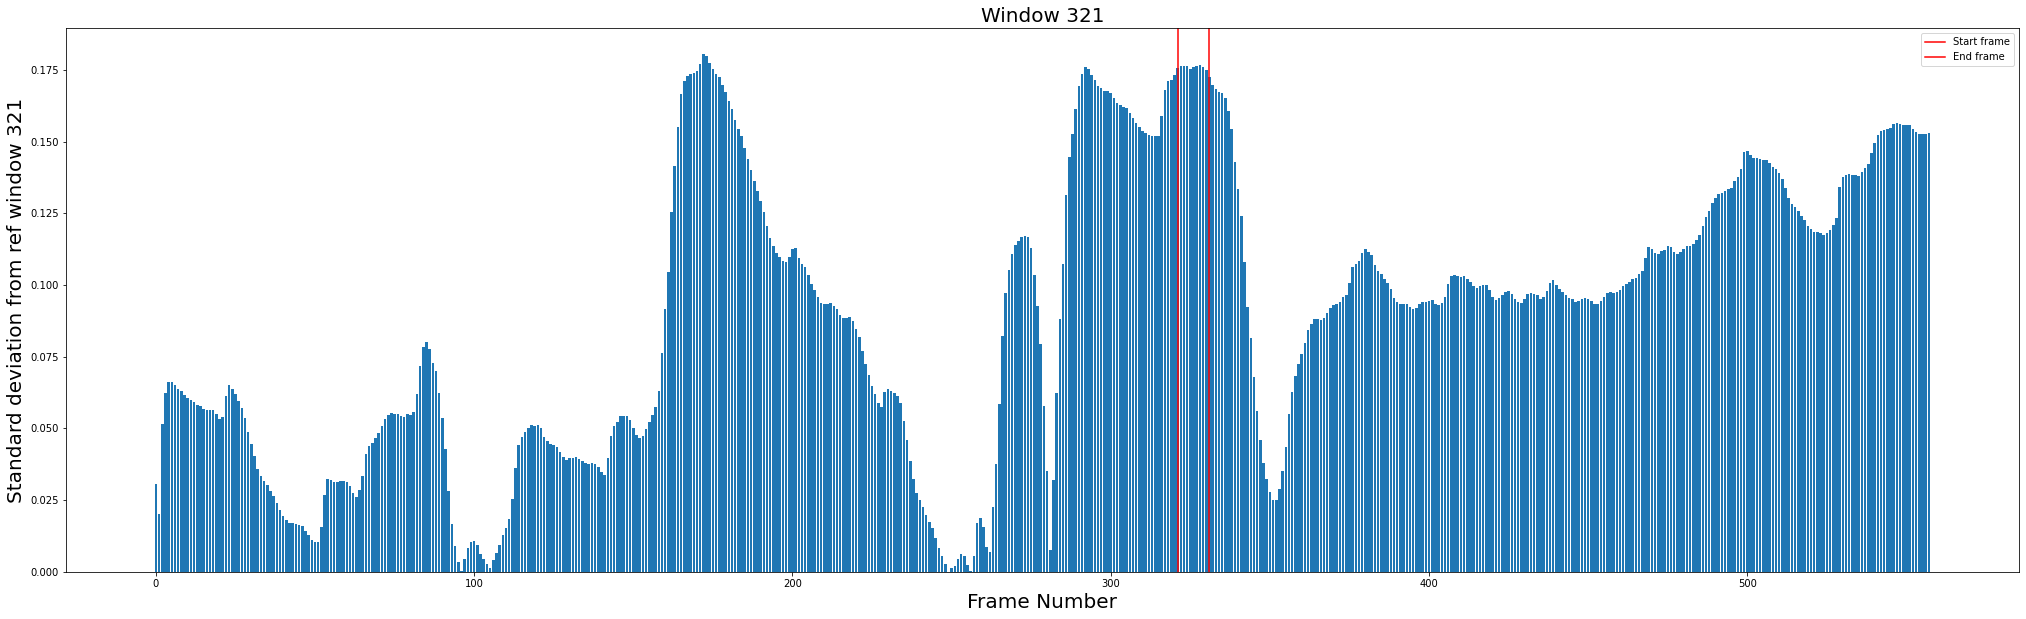

In [223]:


reference_index =100
window_index = 321
size = 10

fig = plt.figure()
fig.set_size_inches(35, 10)
plt.bar(range(0, len(us_data),1), sd_ref_window[reference_index])
plt.axvline(x=window_index, ymin=0, ymax= 900, color='red', label='Start frame')
plt.axvline(x=window_index+size, ymin=0, ymax= 900, color='red', label='End frame')
plt.legend()
plt.ylabel("Standard deviation from ref window %s" %(window_index), size = 20)
plt.xlabel("Frame Number", size = 20)
plt.title(("Window %s" %window_index), size = 20)

![SegmentLocal](win321.gif "us_data_10_frames_sd_ref_win")

Text(0.5, 1.0, 'Window 73')

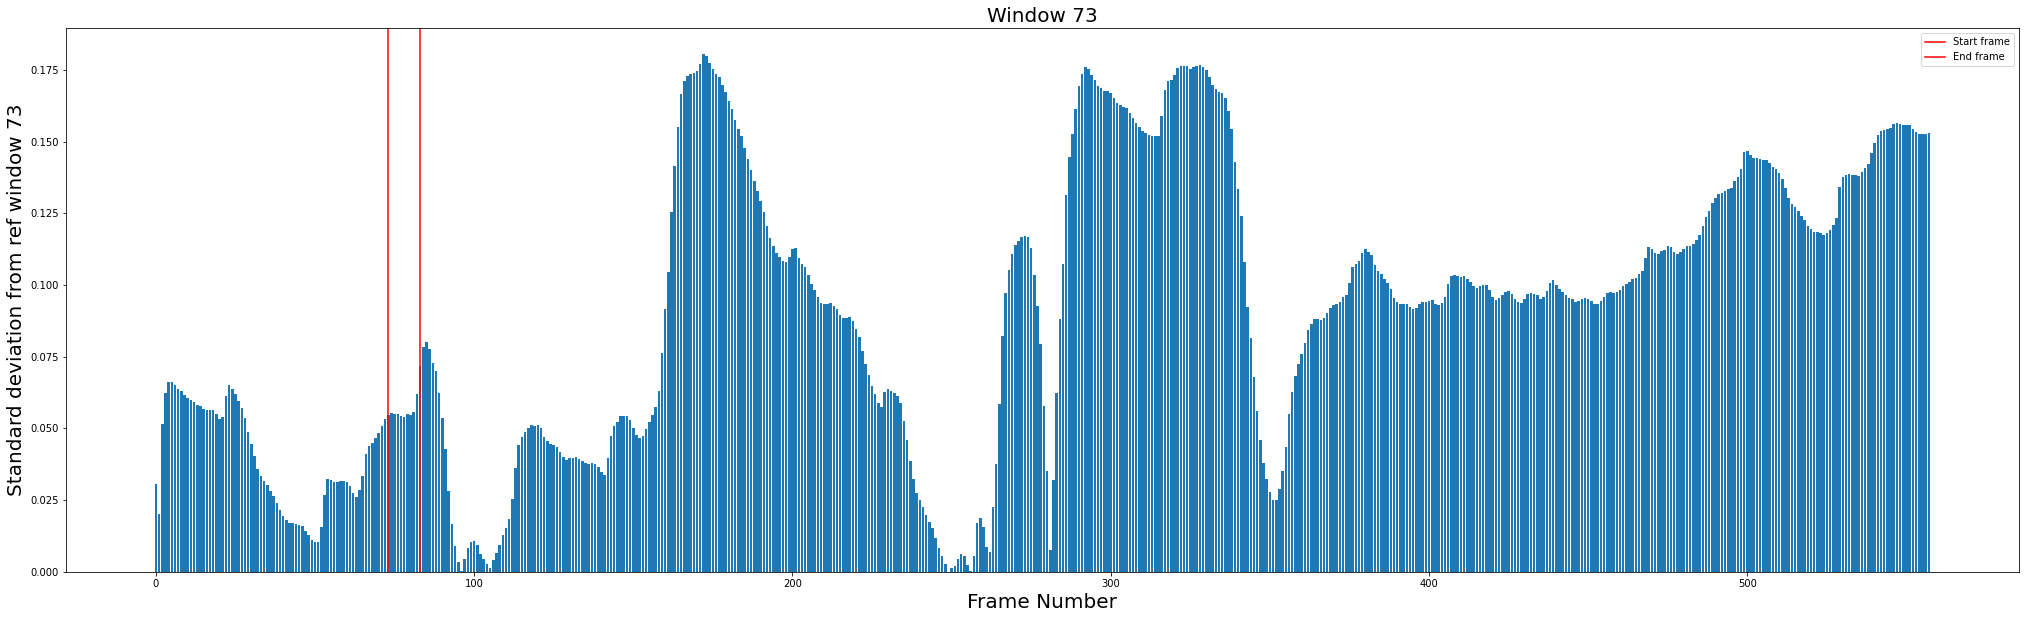

In [224]:

reference_index =100
window_index = 73
size = 10

fig = plt.figure()
fig.set_size_inches(35, 10)
plt.bar(range(0, len(us_data),1), sd_ref_window[reference_index])
plt.axvline(x=window_index, ymin=0, ymax= 900, color='red', label='Start frame')
plt.axvline(x=window_index+size, ymin=0, ymax= 900, color='red', label='End frame')
plt.legend()
plt.ylabel("Standard deviation from ref window %s" %(window_index), size = 20)
plt.xlabel("Frame Number", size = 20)
plt.title("Window %s" %window_index, size = 20)

/Users/angie/miniconda3/lib/python3.7/site-packages/matplotlib/animation.py:974: UserWarning: Animation was deleted without rendering anything. This is most likely unintended. To prevent deletion, assign the Animation to a variable that exists for as long as you need the Animation.
  'Animation was deleted without rendering anything. This is '


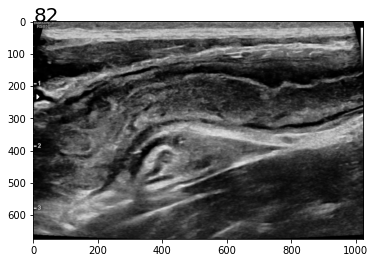

In [101]:
# Animate the 10 frames from window 209
import matplotlib.pyplot as plt
from matplotlib import animation 
import numpy as np

window = 73
ims = []
fig = plt.figure()
ax = fig.add_subplot(111)

for img_num in range(window, window+10,1): #random image for an example
    frame =  ax.imshow(us_data[img_num], cmap = "Greys_r")   
    t = ax.annotate(img_num,(1,1), size = 20) # add text
    ims.append([frame,t]) # add both the image and the text to the list of artists 

anim = animation.ArtistAnimation(fig, ims, interval=350)
anim.save('./win73.gif', writer='pillow')

plt.show()


![SegmentLocal](win73.gif "us_data_10_frames_sd_ref_win")

### Investigating long-term steadiness: 30 Frames

##### * Tested for all reference windows, window 420 yielded the lowest SD in most reference windows. 

In [220]:
# Size of each window, eg. 10 = 10 frames per window 
window_size = 30

# Define the reference window you want to use
srw = sd_ref_window[100]

# Store sd_ref_mean values for each frame, grouped by windows
srw_per_win = []

# Store the mean values of SSE for each window 
mean_per_win = []

# Store the standard deviations of sd_ref_mean for each window
sd_per_win = []


for i in range(len(srw)- window_size):
    window = srw[i:i + window_size]
    srw_per_win.append(srw[i:i + window_size])
    sd_per_win.append(np.std(window))

# Print out window index that has the smallest standard deviation 
index_min = min(range(len(sd_per_win)), key=sd_per_win.__getitem__)
print("The window index that yields the lowest standard deviation: %s" %str(index_min))
print()
print("The standard deviation for this window is: %s" %(sd_per_win[index_min]))



The window index that yields the lowest standard deviation: 420

The standard deviation for this window is: 0.0018866151294146814


Text(0.5, 1.0, 'Window 420')

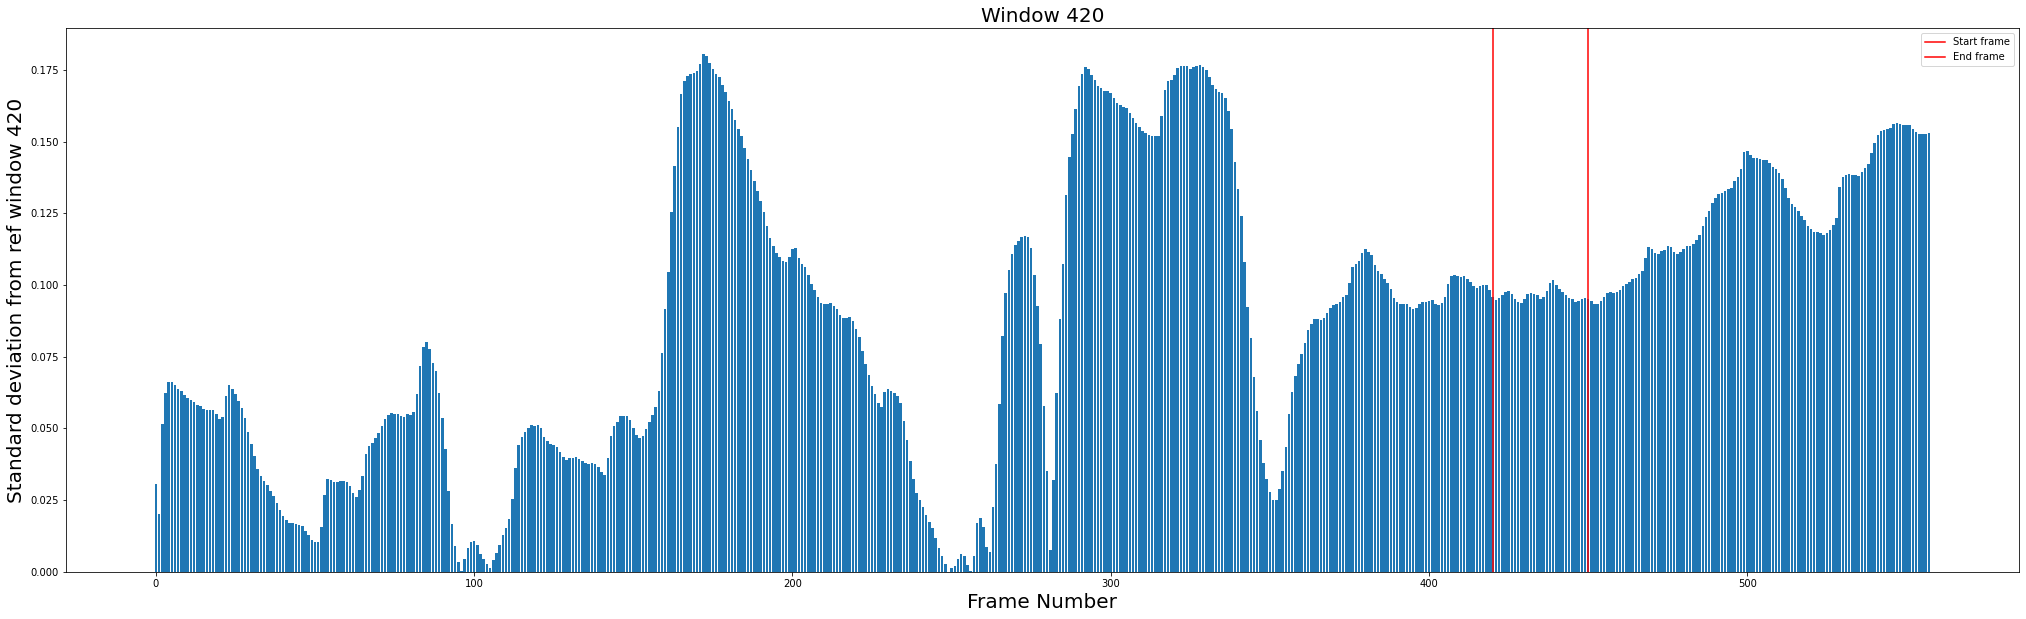

In [225]:
reference_index =100
window_index = 420
size = 30

fig = plt.figure()
fig.set_size_inches(35, 10)
plt.bar(range(0, len(us_data),1), sd_ref_window[reference_index])
plt.axvline(x=window_index, ymin=0, ymax= 900, color='red', label='Start frame')
plt.axvline(x=window_index+size, ymin=0, ymax= 900, color='red', label='End frame')
plt.legend()
plt.ylabel("Standard deviation from ref window %s" %(window_index), size = 20)
plt.xlabel("Frame Number", size = 20)
plt.title(("Window %s" %window_index), size = 20)

![SegmentLocal](win420.gif "us_data_10_frames_sd_ref_win")

### 
# 

## Task 2 & 3: Compute on another image + Alter window size 

##### To make sure that this method can be used on other images
##### For convienence, I computed standard deviation using the average frame as reference with varying window size (10, 20, 30, 40, 50)

#### Load new file: 2640466_0051

In [150]:
us_data, timestep = extract_ultrasound_from_dicom("files/2640466_0051.dcm")

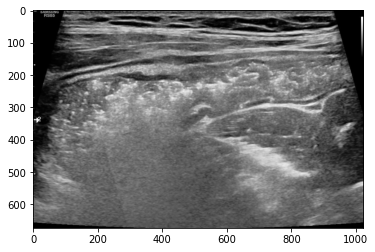

In [155]:
plt.imshow(us_data[2], cmap = "Greys_r")

In [106]:
# A function that outputs the standard deviation from the mean frame to all the other frames

def SD(pixel_data):
    
    # Calculate mean pixel values across all frames, this is used as the "reference frame"
    mean = pixel_data.mean(axis=0)
    
    # store sum of squared = sum of difference between pixel values squared
    sum_squared = []
    sd = []
    
    # Number of frame - 1
    N = pixel_data.shape[0] - 1
    
    # For each frame, calculate the sum of squared error between pixel values of the mean and the frame
    for frame in pixel_data:
        sum_squared.append(np.sum(np.square(np.subtract(frame, mean))))
    
    # For each frame, calculate the standard deviation using SSE between pixel values of the mean and the frame
    for frame in sum_squared:
        sd.append(np.sqrt(np.divide(frame, N)))
    return sd

In [107]:
sd_ref_mean = SD(us_data)

# 

### 10 Frames: window 53 (53 - 63 frames)

In [170]:
# Size of each window, eg. 10 = 10 frames per window 
window_size = 10

# Store sd_ref_mean values for each frame, grouped by windows
srm_per_window = []

# Store the mean values of sd_ref_mean for each window 
mean_per_window = []

# Store the standard deviations of sd_ref_mean for each window
sd_per_window = []



for i in range(len(sd_ref_mean)- window_size):
    window = sd_ref_mean[i:i + window_size]
    srm_per_window.append(sd_ref_mean[i:i + window_size])
    mean_per_window.append(np.mean(window))
    sd_per_window.append(np.std(window))

    
# Print out window index that has the smallest standard deviation 
index_min = min(range(len(sd_per_window)), key=sd_per_window.__getitem__)
print("The window index that yields the lowest standard deviation: %s" %str(index_min))
print()
print("The standard deviation for this window is: %s" %(sd_per_window[index_min]))



The window index that yields the lowest standard deviation: 53

The standard deviation for this window is: 0.6803279105357037


Text(0.5, 1.0, 'Window 53')

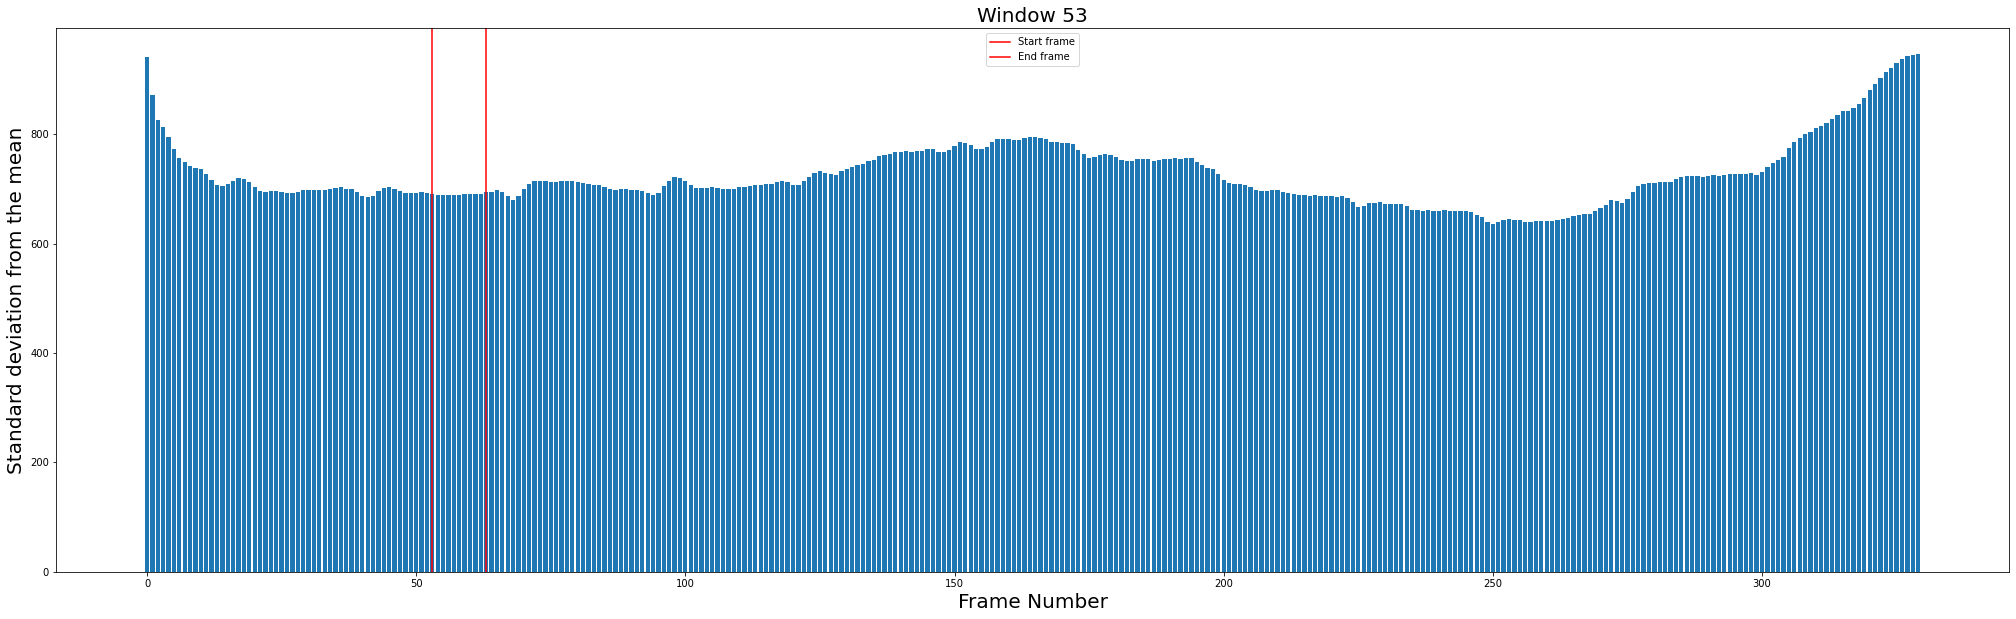

In [110]:
fig = plt.figure()
fig.set_size_inches(35, 10)
plt.bar(range(0, len(sd_ref_mean),1), sd_ref_mean)
plt.axvline(x=53, ymin=0, ymax= 900, color='red', label='Start frame')
plt.axvline(x=53+10, ymin=0, ymax= 900, color='red', label='End frame')
plt.legend()
plt.ylabel("Standard deviation from the mean", size = 20)
plt.xlabel("Frame Number", size = 20)
plt.title("Window 53", size = 20)


![SegmentLocal](win53.gif "us_data_10_frames_sd_ref_win")

### 20 Frames: window 47 (47 - 67 frames)

In [157]:
# Size of each window, eg. 10 = 10 frames per window 
window_size = 20

# Store sd_ref_mean values for each frame, grouped by windows
srm_per_window = []

# Store the mean values of sd_ref_mean for each window 
mean_per_window = []

# Store the standard deviations of sd_ref_mean for each window
sd_per_window = []



for i in range(len(sd_ref_mean)- window_size):
    window = sd_ref_mean[i:i + window_size]
    srm_per_window.append(sd_ref_mean[i:i + window_size])
    mean_per_window.append(np.mean(window))
    sd_per_window.append(np.std(window))

    
# Print out window index that has the smallest standard deviation 
index_min = min(range(len(sd_per_window)), key=sd_per_window.__getitem__)
print("The window index that yields the lowest standard deviation: %s" %str(index_min))
print()
print("The standard deviation for this window is: %s" %(sd_per_window[index_min]))



The window index that yields the lowest standard deviation: 47

The standard deviation for this window is: 2.4471570299563687


Text(0.5, 1.0, 'Window 47')

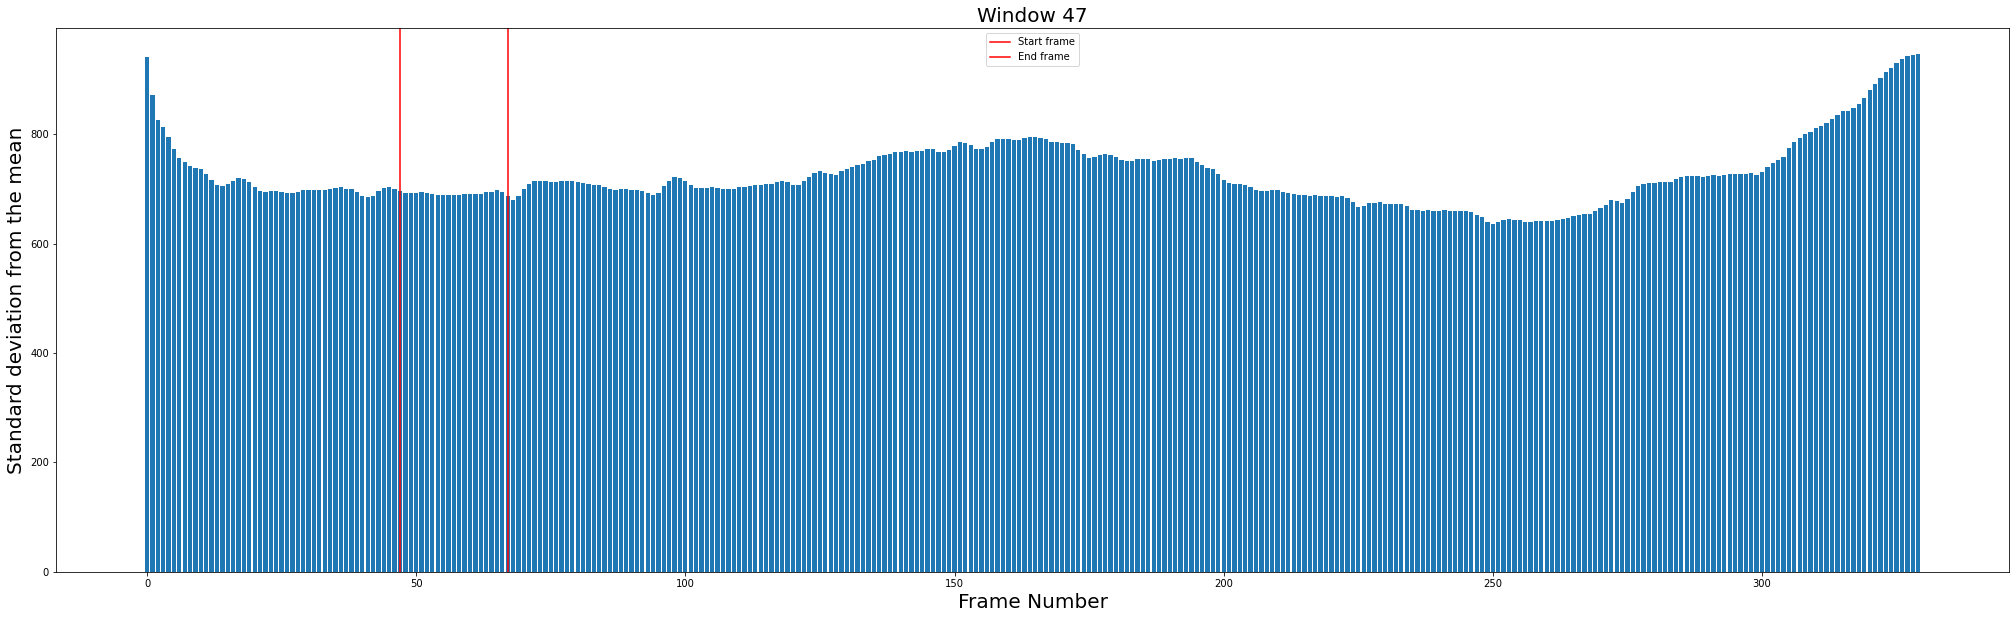

In [158]:
window_index = 47
size = 20

fig = plt.figure()
fig.set_size_inches(35, 10)
plt.bar(range(0, len(sd_ref_mean),1), sd_ref_mean)
plt.axvline(x=window_index, ymin=0, ymax= 900, color='red', label='Start frame')
plt.axvline(x=window_index+size, ymin=0, ymax= 900, color='red', label='End frame')
plt.legend()
plt.ylabel("Standard deviation from the mean", size = 20)
plt.xlabel("Frame Number", size = 20)
plt.title(("Window %s" %window_index), size = 20)


### 30 Frames: window 21 (21 - 51 frames)

In [159]:
# Size of each window, eg. 10 = 10 frames per window 
window_size = 30

# Store sd_ref_mean values for each frame, grouped by windows
srm_per_window = []

# Store the mean values of sd_ref_mean for each window 
mean_per_window = []

# Store the standard deviations of sd_ref_mean for each window
sd_per_window = []



for i in range(len(sd_ref_mean)- window_size):
    window = sd_ref_mean[i:i + window_size]
    srm_per_window.append(sd_ref_mean[i:i + window_size])
    mean_per_window.append(np.mean(window))
    sd_per_window.append(np.std(window))

    
# Print out window index that has the smallest standard deviation 
index_min = min(range(len(sd_per_window)), key=sd_per_window.__getitem__)
print("The window index that yields the lowest standard deviation: %s" %str(index_min))
print()
print("The standard deviation for this window is: %s" %(sd_per_window[index_min]))



The window index that yields the lowest standard deviation: 21

The standard deviation for this window is: 4.346993650366124


Text(0.5, 1.0, 'Window 21')

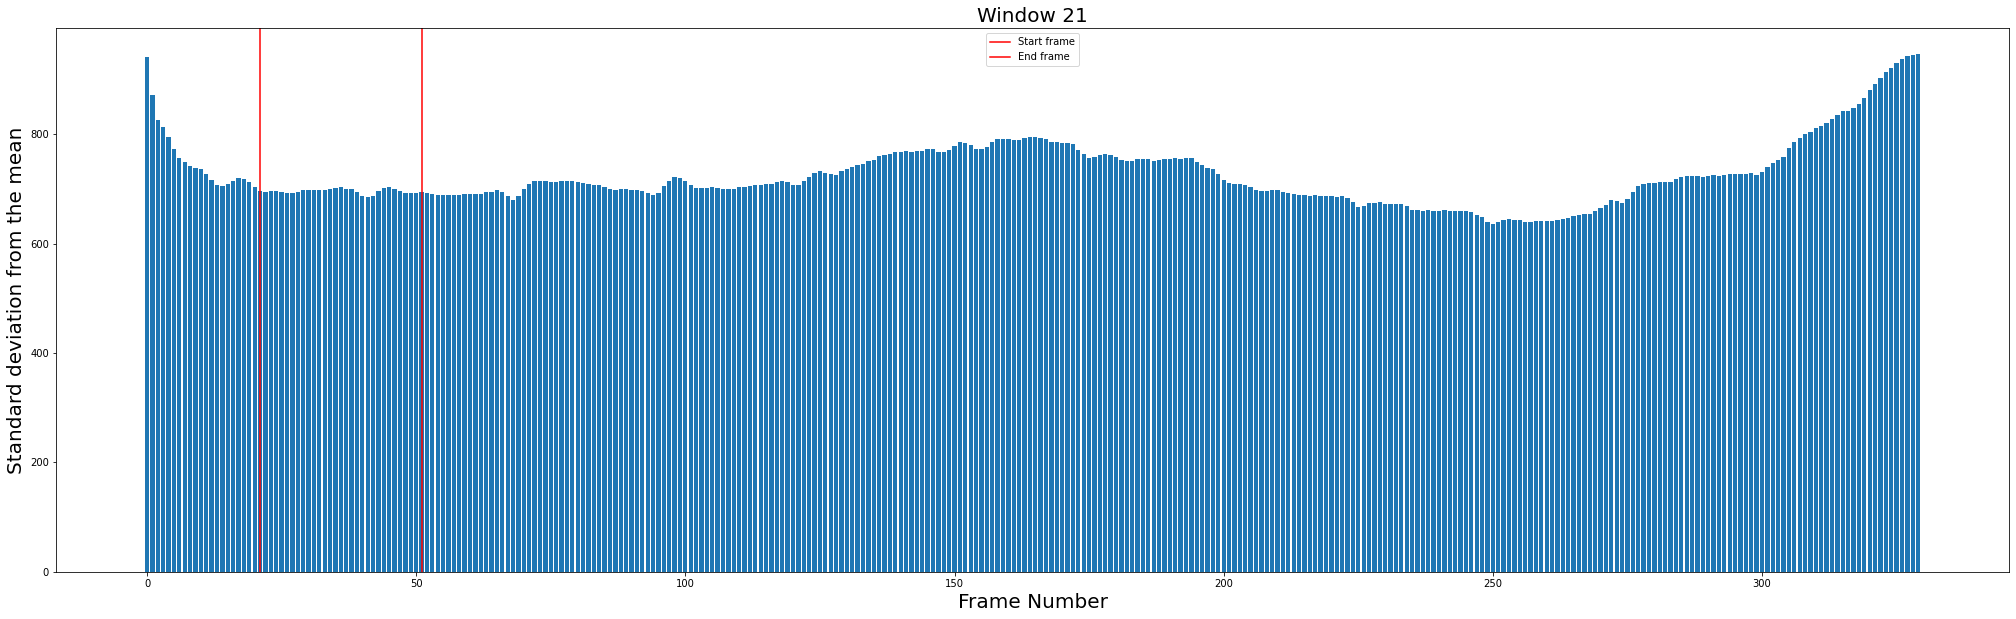

In [160]:
window_index = 21
size = 30

fig = plt.figure()
fig.set_size_inches(35, 10)
plt.bar(range(0, len(sd_ref_mean),1), sd_ref_mean)
plt.axvline(x=window_index, ymin=0, ymax= 900, color='red', label='Start frame')
plt.axvline(x=window_index+size, ymin=0, ymax= 900, color='red', label='End frame')
plt.legend()
plt.ylabel("Standard deviation from the mean", size = 20)
plt.xlabel("Frame Number", size = 20)
plt.title(("Window %s" %window_index), size = 20)


### 40 Frames: window 21 (21 - 61 frames)

In [129]:
# Size of each window, eg. 10 = 10 frames per window 
window_size = 40

# Store sd_ref_mean values for each frame, grouped by windows
srm_per_window = []

# Store the mean values of sd_ref_mean for each window 
mean_per_window = []

# Store the standard deviations of sd_ref_mean for each window
sd_per_window = []



for i in range(len(sd_ref_mean)- window_size):
    window = sd_ref_mean[i:i + window_size]
    srm_per_window.append(sd_ref_mean[i:i + window_size])
    mean_per_window.append(np.mean(window))
    sd_per_window.append(np.std(window))

    
# Print out window index that has the smallest standard deviation 
index_min = min(range(len(sd_per_window)), key=sd_per_window.__getitem__)
print("The window index that yields the lowest standard deviation: %s" %str(index_min))
print()
print("The standard deviation for this window is: %s" %(sd_per_window[index_min]))



The window index that yields the lowest standard deviation: 21

The standard deviation for this window is: 4.4899126606680735


Text(0.5, 1.0, 'Window 21')

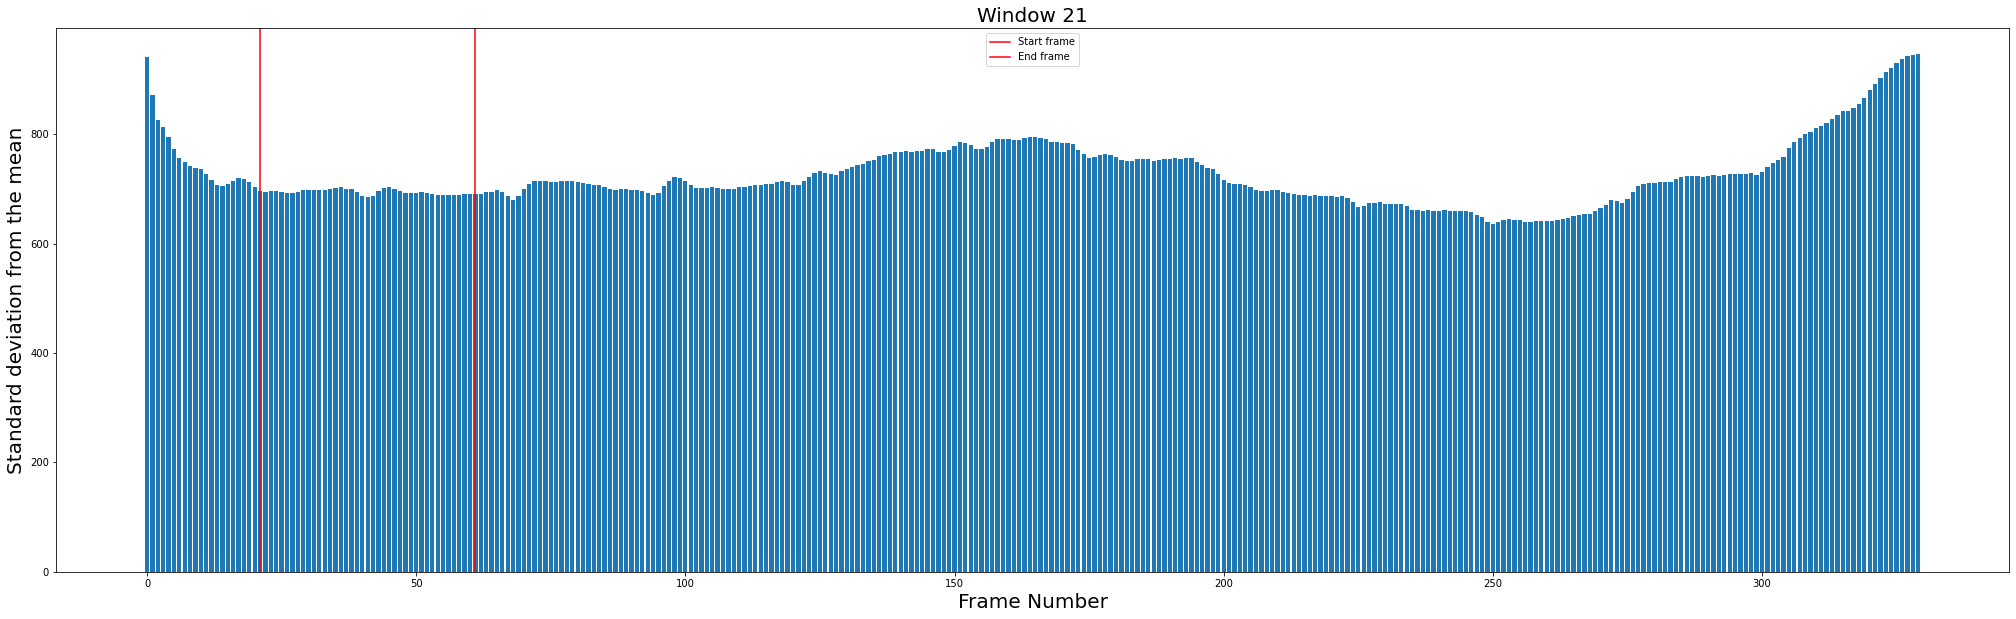

In [164]:
window_index = 21
size = 40

fig = plt.figure()
fig.set_size_inches(35, 10)
plt.bar(range(0, len(sd_ref_mean),1), sd_ref_mean)
plt.axvline(x=window_index, ymin=0, ymax= 900, color='red', label='Start frame')
plt.axvline(x=window_index+size, ymin=0, ymax= 900, color='red', label='End frame')
plt.legend()
plt.ylabel("Standard deviation from the mean", size = 20)
plt.xlabel("Frame Number", size = 20)
plt.title(("Window %s" %window_index), size = 20)


![SegmentLocal](win21.gif "us_data_10_frames_sd_ref_win")

### 50 Frames: window 21 (21 - 71 frames)

In [161]:
 # Size of each window, eg. 10 = 10 frames per window 
window_size = 50

# Store sd_ref_mean values for each frame, grouped by windows
srm_per_window = []

# Store the mean values of sd_ref_mean for each window 
mean_per_window = []

# Store the standard deviations of sd_ref_mean for each window
sd_per_window = []



for i in range(len(sd_ref_mean)- window_size):
    window = sd_ref_mean[i:i + window_size]
    srm_per_window.append(sd_ref_mean[i:i + window_size])
    mean_per_window.append(np.mean(window))
    sd_per_window.append(np.std(window))

    
# Print out window index that has the smallest standard deviation 
index_min = min(range(len(sd_per_window)), key=sd_per_window.__getitem__)
print("The window index that yields the lowest standard deviation: %s" %str(index_min))
print()
print("The standard deviation for this window is: %s" %(sd_per_window[index_min]))



The window index that yields the lowest standard deviation: 21

The standard deviation for this window is: 4.939883703655905


Text(0.5, 1.0, 'Window 21')

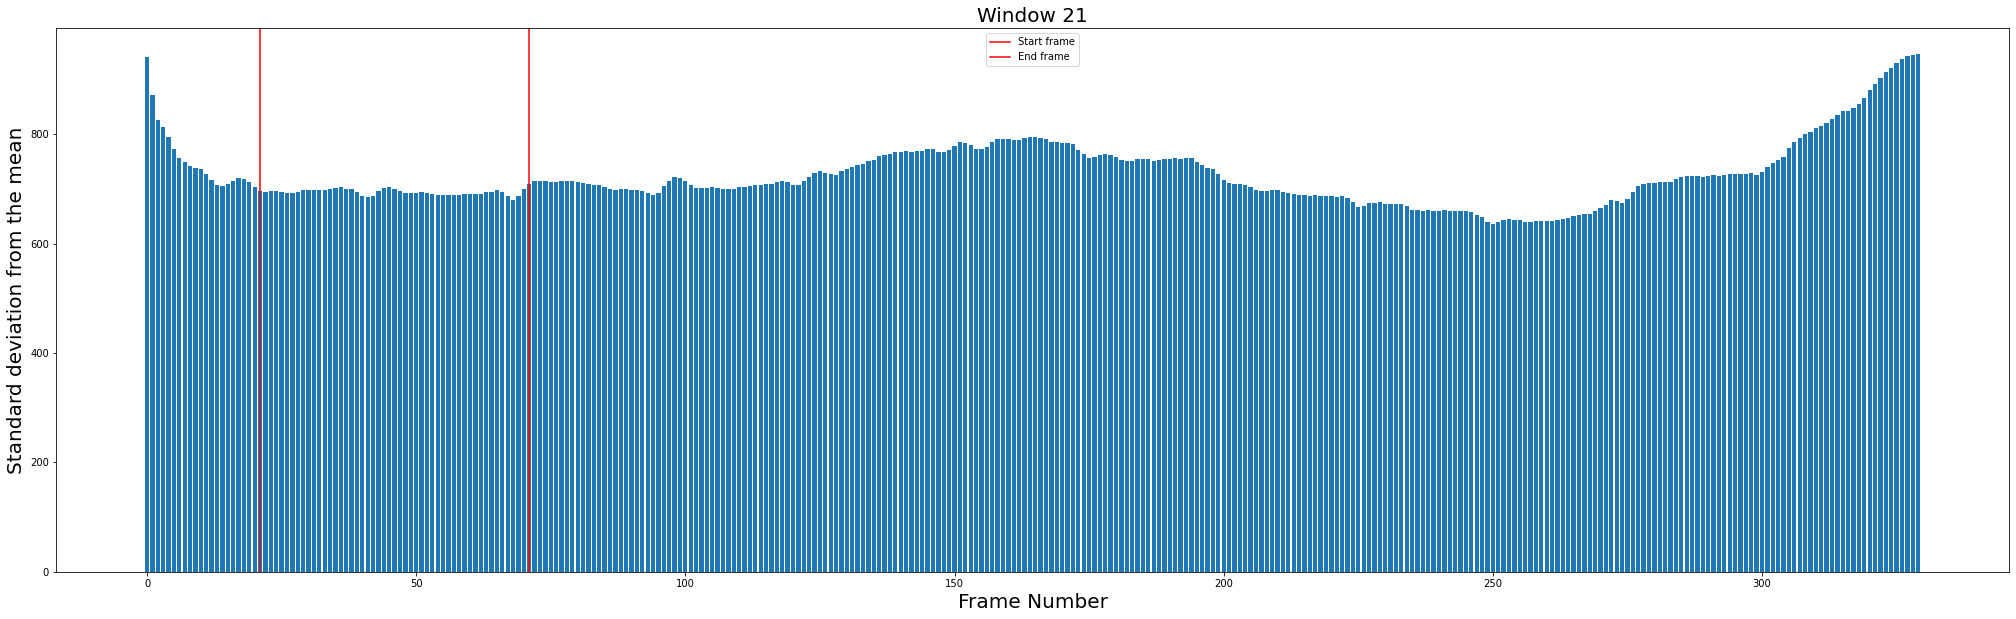

In [162]:
window_index = 21
size = 50

fig = plt.figure()
fig.set_size_inches(35, 10)
plt.bar(range(0, len(sd_ref_mean),1), sd_ref_mean)
plt.axvline(x=window_index, ymin=0, ymax= 900, color='red', label='Start frame')
plt.axvline(x=window_index+size, ymin=0, ymax= 900, color='red', label='End frame')
plt.legend()
plt.ylabel("Standard deviation from the mean", size = 20)
plt.xlabel("Frame Number", size = 20)
plt.title(("Window %s" %window_index), size = 20)


#### General thoughts

##### * The start region of this image file is more steady, selection starts from around frame 50 (window size 10) and going towards frame 21
##### * Even with multiple window sizes, the window/frames that are selected are situated around the same area of the graph (21 - 71 frames)

# 
# 
# 
---------
----

# NEW PROGRESS!
######  
# Week 5 - June 7th
* Group frames into windows based on the given window size
* Generate reference windows by taking the mean pixel values of all frames in a window
* Compute sum of squared difference between frames in each window and its reference window
* Write a function that does the above tasks and ouputs the sum of squared differences
#### 
###### Equations:

![SegmentLocal](get_attachment_url.png "equation")


 
### Make a temporary dataset with 10 frames -> `data`
* I created a smaller dataset that consists of 10 frames to avoid computational problems for this task

In [9]:
data = us_data[0:10]

In [10]:
data.shape

(10, 674, 1024)

##### 

### Create `pixel windows` (groups of frames), based on the given window size

In [18]:
# DEFINE WINDOW SIZE AND GROUP FRAMES IN ADVANCE ACCORDING TO WINDOW SIZE:
#### In this case the window size is 2, so window 0 should have <frame 0, frame 1>, window 1 should have <frame 1, frame 2> ....

window_size = 2
pixel_window = []

for i in range(len(data)- window_size):
    window = data[i:i + window_size]
    pixel_window.append(data[i:i + window_size])


In [230]:
#### To test if this worked the way it should, I will test this out using window 5
####       In theory, window 5 should contain <frame 5, frame 6>
####       I created a object called "zipped" that contains <frame 5, frame 6> to test if they match up using 'np.array_equal'

pixel_window[5]

array([[[177, 177, 177, ...,   0,   0,   0],
        [178, 178, 178, ...,   0,   0,   0],
        [174, 190, 169, ...,   0,   0,   0],
        ...,
        [  0,   0,   0, ...,   0,   0,   0],
        [  0,   0,   0, ...,   0,   0,   0],
        [  0,   0,   0, ...,   0,   0,   0]],

       [[177, 177, 177, ...,   0,   0,   0],
        [178, 178, 178, ...,   0,   0,   0],
        [174, 190, 169, ...,   0,   0,   0],
        ...,
        [  0,   0,   0, ...,   0,   0,   0],
        [  0,   0,   0, ...,   0,   0,   0],
        [  0,   0,   0, ...,   0,   0,   0]]], dtype=uint8)

In [305]:
zipped = np.stack((data[5], data[6]))

In [306]:
zipped

array([[[177, 177, 177, ...,   0,   0,   0],
        [178, 178, 178, ...,   0,   0,   0],
        [174, 190, 169, ...,   0,   0,   0],
        ...,
        [  0,   0,   0, ...,   0,   0,   0],
        [  0,   0,   0, ...,   0,   0,   0],
        [  0,   0,   0, ...,   0,   0,   0]],

       [[177, 177, 177, ...,   0,   0,   0],
        [178, 178, 178, ...,   0,   0,   0],
        [174, 190, 169, ...,   0,   0,   0],
        ...,
        [  0,   0,   0, ...,   0,   0,   0],
        [  0,   0,   0, ...,   0,   0,   0],
        [  0,   0,   0, ...,   0,   0,   0]]], dtype=uint8)

In [233]:
#### The arrays are identical
np.array_equal(zipped, pixel_window[5])

True

# 

### Create `reference window`

In [14]:
# CREATE REFERENCE WINDOWS BY TAKING THE MEAN PIXEL VALUES OF FRAMES IN EACH WINDOW

window_size = 2
reference_window = []

for i in range(len(data)- window_size):
    window = data[i:i + window_size]
    reference_window.append(window.mean(axis = 0))


[[[177 177 177 ...   0   0   0]
  [178 178 178 ...   0   0   0]
  [174 190 169 ...   0   0   0]
  ...
  [  0   0   0 ...   0   0   0]
  [  0   0   0 ...   0   0   0]
  [  0   0   0 ...   0   0   0]]

 [[177 177 177 ...   0   0   0]
  [178 178 178 ...   0   0   0]
  [174 190 169 ...   0   0   0]
  ...
  [  0   0   0 ...   0   0   0]
  [  0   0   0 ...   0   0   0]
  [  0   0   0 ...   0   0   0]]]
[[[177 177 177 ...   0   0   0]
  [178 178 178 ...   0   0   0]
  [174 190 169 ...   0   0   0]
  ...
  [  0   0   0 ...   0   0   0]
  [  0   0   0 ...   0   0   0]
  [  0   0   0 ...   0   0   0]]

 [[177 177 177 ...   0   0   0]
  [178 178 178 ...   0   0   0]
  [174 190 169 ...   0   0   0]
  ...
  [  0   0   0 ...   0   0   0]
  [  0   0   0 ...   0   0   0]
  [  0   0   0 ...   0   0   0]]]
[[[177 177 177 ...   0   0   0]
  [178 178 178 ...   0   0   0]
  [174 190 169 ...   0   0   0]
  ...
  [  0   0   0 ...   0   0   0]
  [  0   0   0 ...   0   0   0]
  [  0   0   0 ...   0   0   0]]



In [323]:
#### Each reference window is the average pixel values of all the frames in that particular window
reference_window[0]

array([[177., 177., 177., ...,   0.,   0.,   0.],
       [178., 178., 178., ...,   0.,   0.,   0.],
       [174., 190., 169., ...,   0.,   0.,   0.],
       ...,
       [  0.,   0.,   0., ...,   0.,   0.,   0.],
       [  0.,   0.,   0., ...,   0.,   0.,   0.],
       [  0.,   0.,   0., ...,   0.,   0.,   0.]])

#### 

### Compute `sum of squared difference `

In [313]:
# COMPUTE THE SUM OF DIFFERENCE SQUARED BETWEEN EACH WINDOW AND ITS REFERENCE WINDOW

sum_diff_squared = []
#sd = []


for frame, reference in zip(pixel_window, reference_window):
    sum_diff_squared.append(np.sum(np.square(np.subtract(frame, reference))))
    #sd.append(np.std(np.square(np.subtract(frame, reference))))


In [314]:
sum_diff_squared

[4276382.0,
 8173670.5,
 2920876.5,
 2513283.5,
 2124824.5,
 1847891.0,
 1121319.0,
 1132827.0]

In [ ]:
#### A TEST TO SEE WHAT I HAVE DONE ABOVE IS CORRECT
####    If I purposely use reference window 5 as the reference, in theory the sum of squared difference value 
####    should be the same as the above at index 5  (1847891.0)

test = []

for x in pixel_window:
    test.append(np.sum(np.square(np.subtract(x,reference_window[5]))))

In [285]:
test

[164370020.0,
 99401005.0,
 46611862.0,
 22087545.0,
 7045166.0,
 1847891.0,
 4468252.0,
 10071651.0]

In [315]:
#### The values matched up
np.array_equal(test[5], sum_diff_squared[5])

True

### 

### Make this into a `function`

* This function takes 2 arguments: (1) `pixel ultrasound data` (2) `window size` (number of frames in a window)
* The output produces the "sum of squared difference" between frames in each window with its corresponding reference window

* I will also show the time it takes to use this function on different data sizes and window sizes

In [291]:
def steadiness(pixel_data, window_size):
    sum_diff_squared = []
    
    for i in range(len(pixel_data) - window_size):
        pixel_window = pixel_data[i:i + window_size]
        reference_window = pixel_window.mean(axis = 0)
        
        
        sum_diff_squared.append(np.sum(np.square(np.subtract(pixel_window, reference_window))))
        
    return sum_diff_squared
        

#### * Testing the function on the example dataset `(total of 10 frames with window size 2)`

In [304]:
x = steadiness(data, 2)

In [311]:
import time
start_time = time.time()

x = steadiness(data, 2)

print("---This task takes %s seconds to run---" % (time.time() - start_time))


---This task takes 0.09705114364624023 seconds to run---


In [293]:
x

[4276382.0,
 8173670.5,
 2920876.5,
 2513283.5,
 2124824.5,
 1847891.0,
 1121319.0,
 1132827.0]

### 

#### * Testing the function on a bigger dataset `(total of 558 frames with window size of 10)`

In [200]:
y = steadiness(us_data, 10)

In [300]:
start_time = time.time()

y = steadiness(us_data, 10)

print("--- %s seconds ---" % (time.time() - start_time))

--- 29.29018497467041 seconds ---


In [202]:
len(y)

548

In [318]:
# Display the first 20 sum of squared differences
y[0:20]

[163400791.10000002,
 121323451.19999993,
 86982586.80000007,
 79051713.2,
 78218891.29999986,
 80517080.19999997,
 83597900.49999991,
 85328621.1999999,
 84831745.39999999,
 82147617.00000001,
 80932692.59999996,
 76394313.99999993,
 66632956.69999994,
 61185327.50000001,
 71139012.89999992,
 96673042.99999999,
 133270456.29999995,
 175718545.80000007,
 210046670.29999992,
 230418245.79999986]

##### 

#### * Testing the function on a bigger dataset `(total of 558 frames with window size of 30)`

In [ ]:
z = steadiness(us_data, 30)

In [325]:
start_time = time.time()

z = steadiness(us_data, 30)

print("--- %s seconds ---" % (time.time() - start_time))

--- 129.50022888183594 seconds ---


In [327]:
len(z)

528

In [326]:
# Display the first 20 sum of squared differences
z[0:20]

[938127781.9999993,
 937089004.2333343,
 946059751.266668,
 975945535.2333333,
 1007282633.566666,
 1037543443.9666642,
 1065046904.433333,
 1095671849.666667,
 1126486028.800001,
 1154060477.5999992,
 1178151562.0999992,
 1201057324.7333333,
 1225804493.833333,
 1259634291.9000022,
 1296281333.3333325,
 1330039829.3999991,
 1355095840.9333327,
 1361518388.9999986,
 1349696113.866665,
 1323833581.2333348]

# 

## Let's try importing the function from `angie_functions` and use it

In [4]:
from angie_functions import steadiness

In [9]:
data = us_data[0:10]

In [12]:
sum_of_squared_diff = steadiness(data, 2)

In [13]:
sum_of_squared_diff

[4276382.0,
 8173670.5,
 2920876.5,
 2513283.5,
 2124824.5,
 1847891.0,
 1121319.0,
 1132827.0]